# Redes Feed Forward

Esse notebook implementa uma rede neural *feed forward* ou MLP para prever o consumo por cimento

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

sns.set_palette("Set2")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

# Funções e constantes

### Constantes que definimos

ANO_INICIAL = 1991
ANO_FINAL = 2019

PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/data/csv/"

N_STATES=27

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%",
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

In [3]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [4]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [5]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))

    sns.countplot(data=error, x='categoria', order=LABELS)

    plt.show()

In [6]:
def show_predictions_graphs (data):

    plt.figure(figsize=(24,45))

    for state in range(27):

        plt.subplot(9,3,state+1)
        
        plt.yscale('linear')

        plt.title (f"Distribuição do erro do estado {SIGLAS[state]}")

        # pred = y_pred[state]
        # real = y_test[state]

        plt.plot(pd.DataFrame(data[SIGLAS[state]]["y_pred"]), label="Previsão", color="coral")
        plt.plot(pd.DataFrame(data[SIGLAS[state]]["y_test"]), label="Dado Real", color="darkgreen")

        plt.legend()
    plt.show()

In [7]:
def split_y_state (y):

    if type(y) == np.ndarray:

        return dict(zip([i for i in range(27)], [[y[i] for i in range(s, len(y), 27)] for s in range(27)]))

    return dict(zip([i for i in range(27)], [[y.iloc[i] for i in range(s, y.size, 27)] for s in range(27)]))


# Ler dados e obter erro

In [9]:
df_geral = pd.DataFrame(["RMSE", "MAPE", "MAE"], columns=["indicador"])

In [8]:
x = pd.read_csv(PATH+"input.csv")

x= pd.get_dummies(data=x, columns=["estados"], drop_first=True)
x = x.drop(["data"], axis=1)

y = pd.read_csv(PATH + "target_ac.csv")
y = y["consumo"]

# Modelo

## StandardScaler

In [11]:
y = pd.read_csv(PATH + "target_ac.csv")
y = y["consumo"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),
model.add(Dense(units=8, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

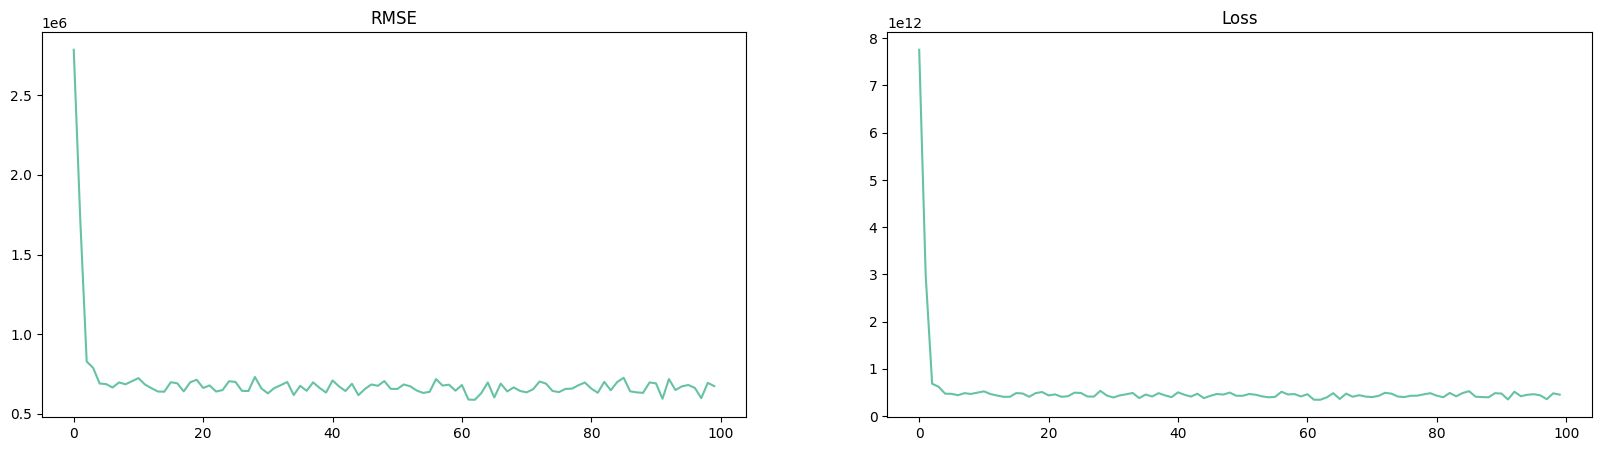

In [12]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [13]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

45/45 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 832071.8899540277
MAE: 533653.1241799645
MAPE: 0.5105148908753523


In [14]:
df_geral["standard scaler"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

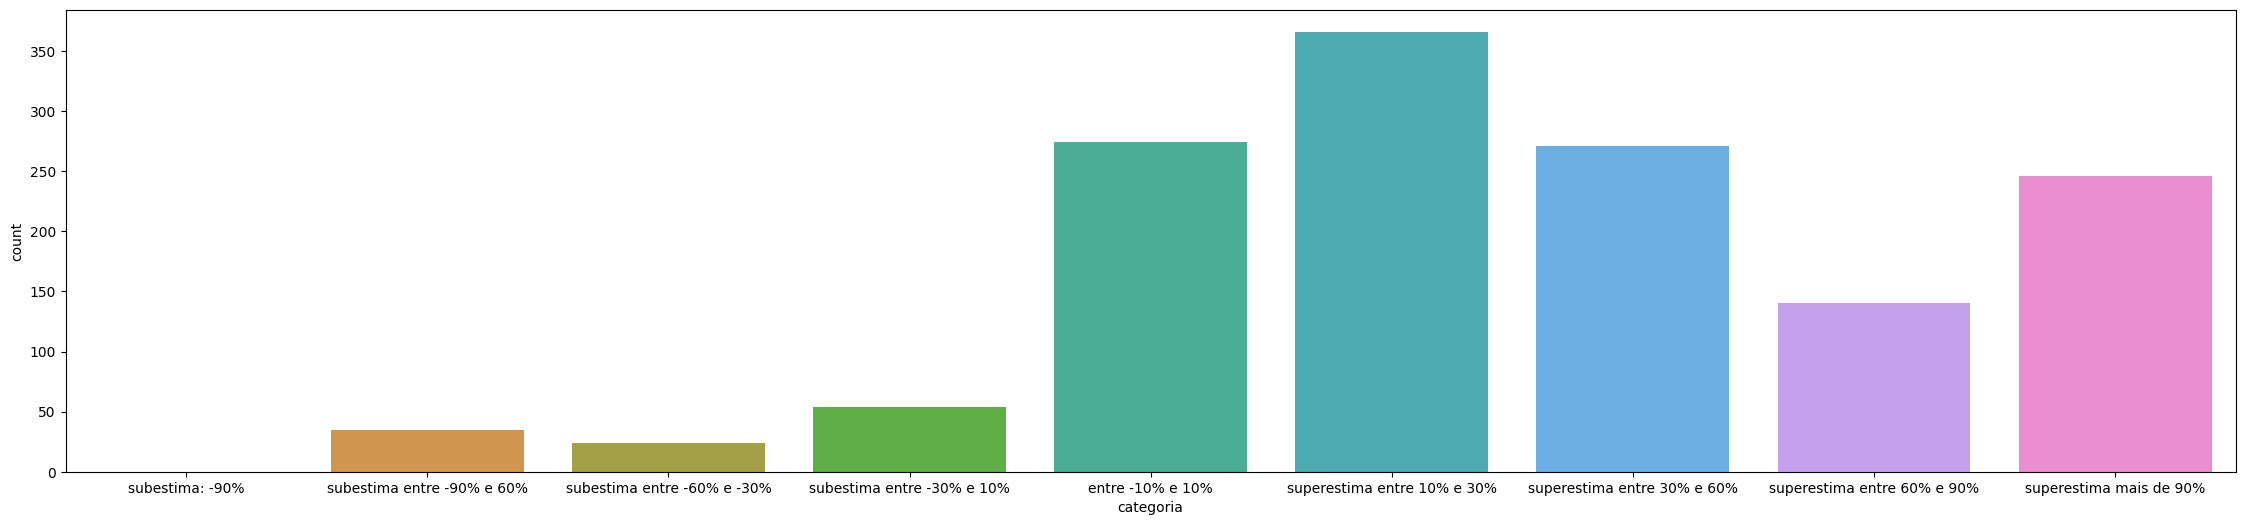

In [15]:
show_delta(np.array(y_test), y_pred.flatten())

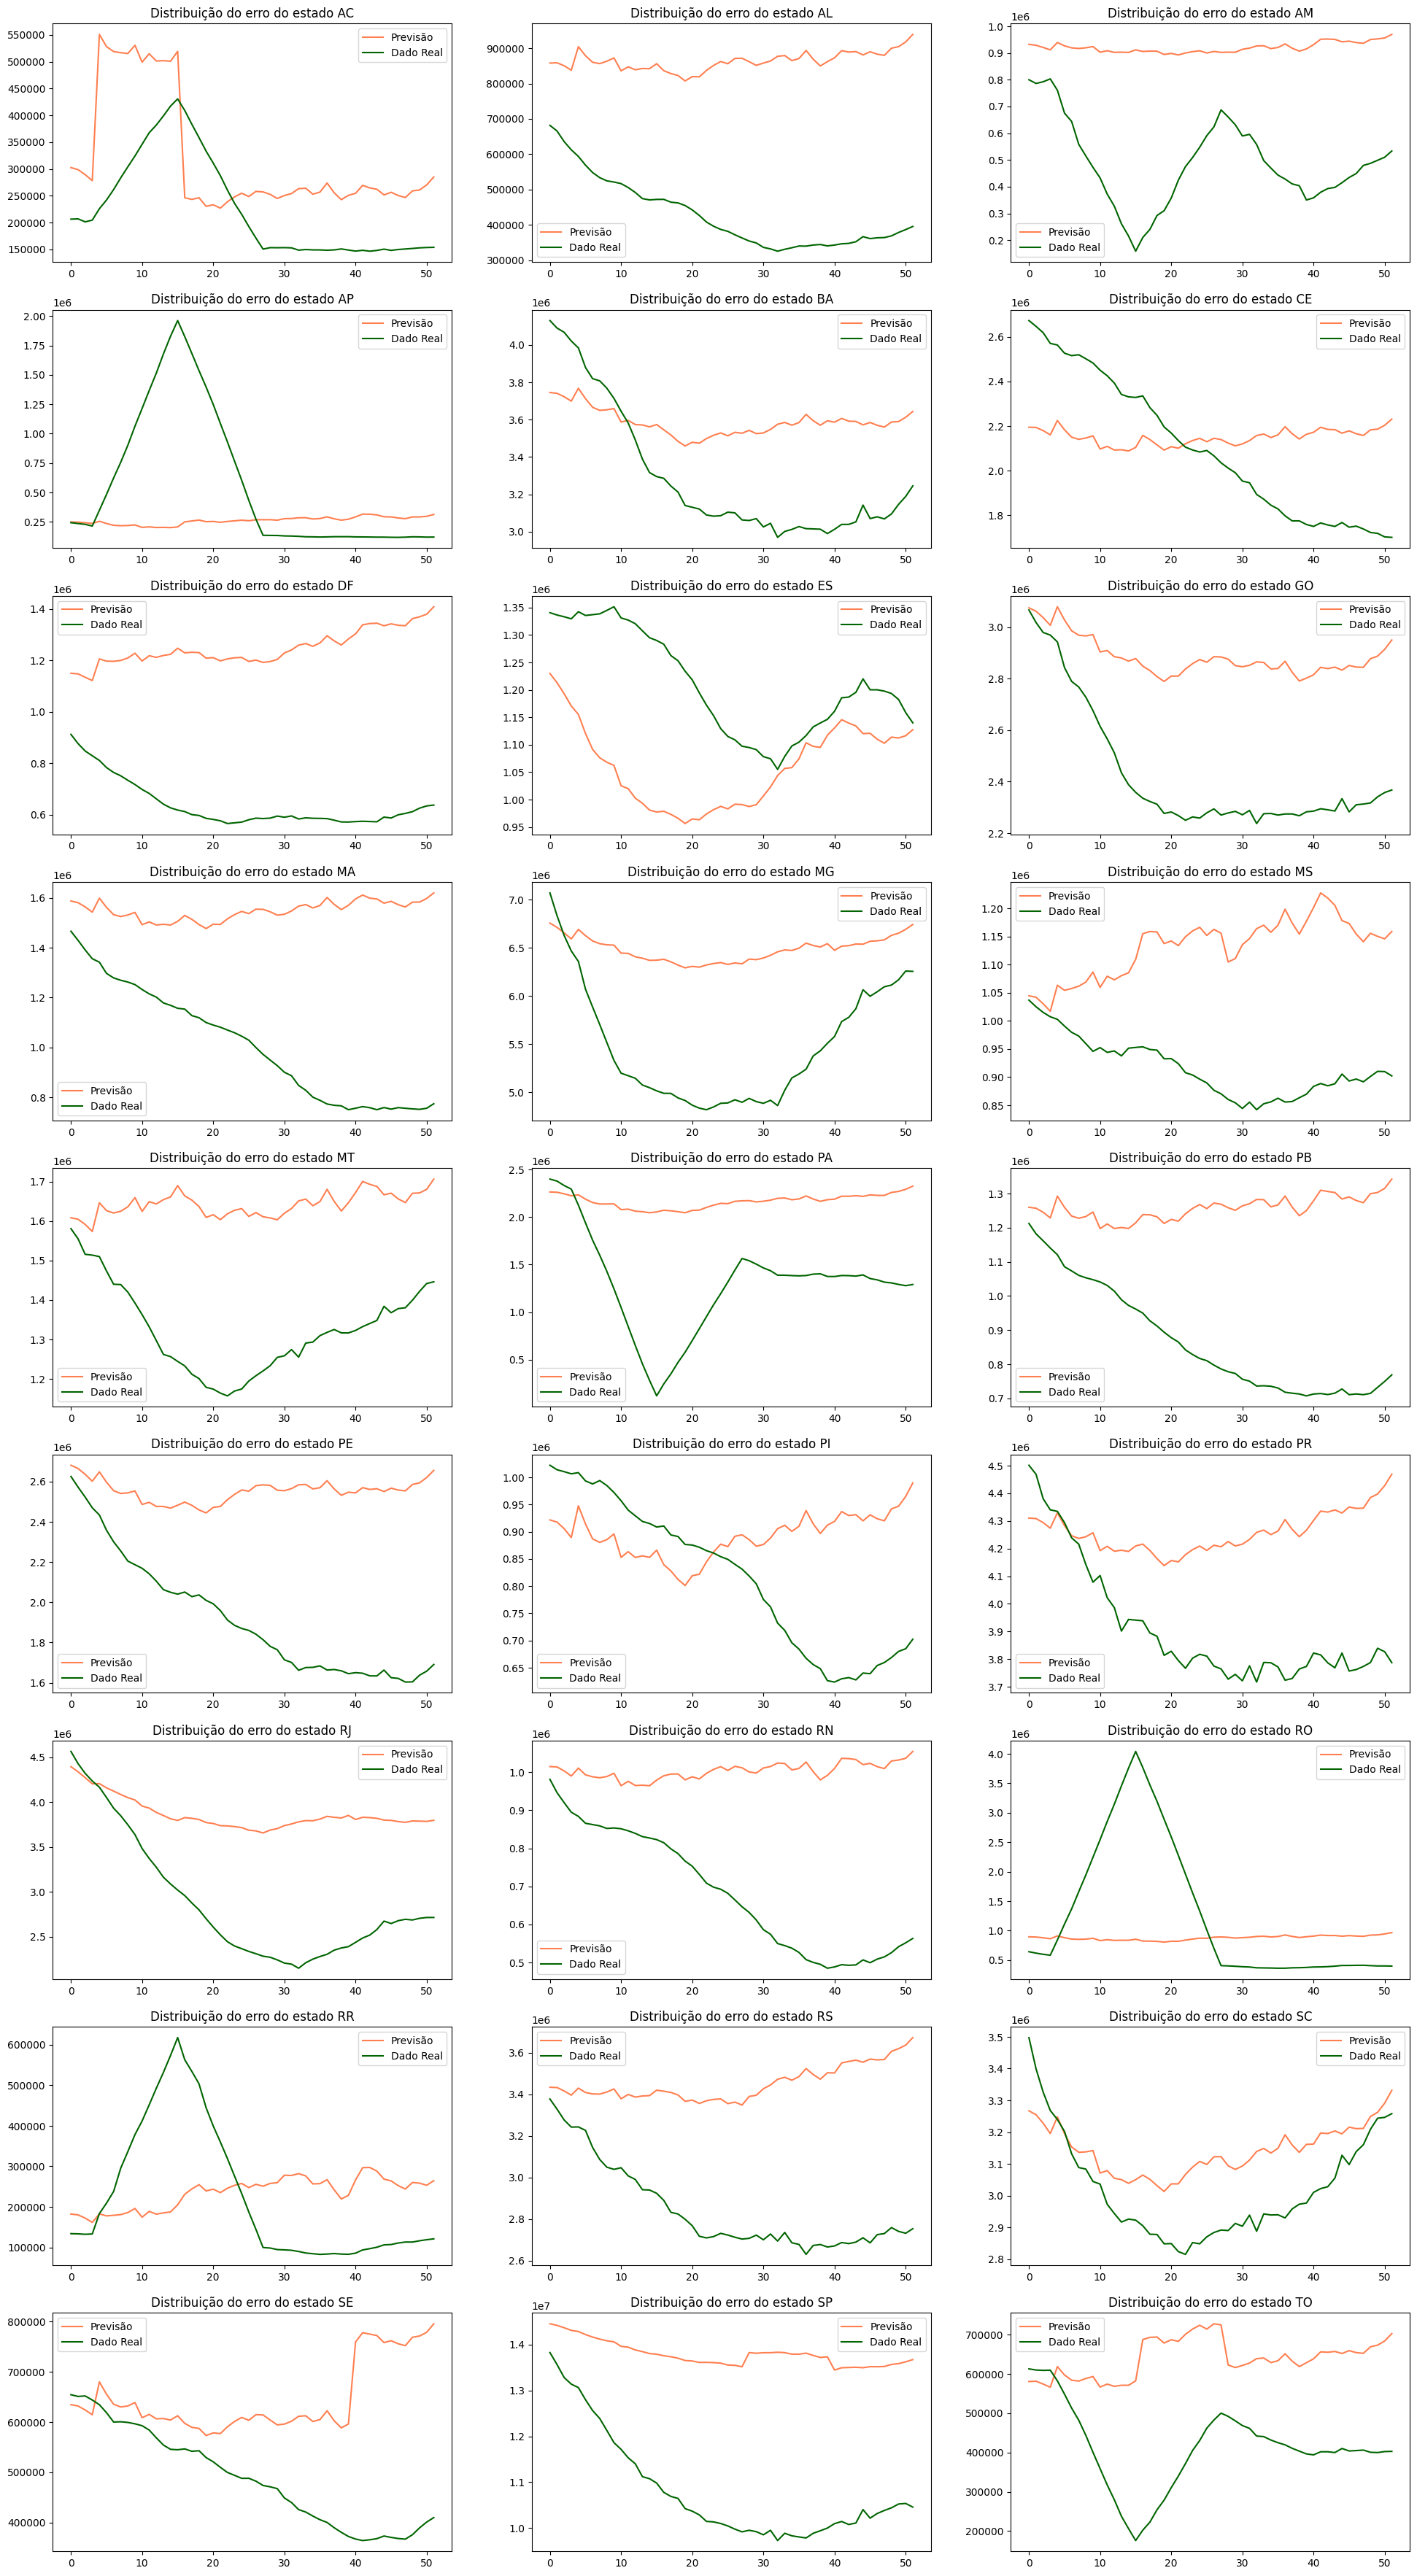

In [16]:
y_pred = y_pred[6:]
y_test = y_test[6:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)

## MinMax Scaler

In [17]:
y = pd.read_csv(PATH + "target_ac.csv")
y = y["consumo"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),

model.add(Dense(units=8, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

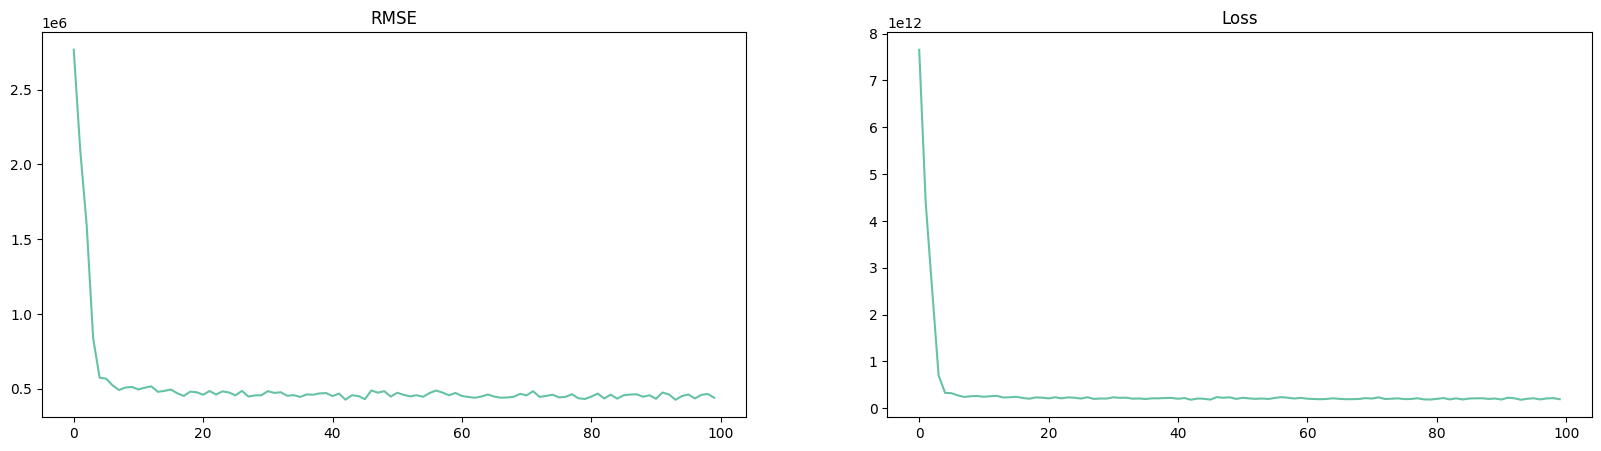

In [18]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [19]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

45/45 [==============================] - 1s 4ms/step
Scores obtidos:
RMSE: 923444.3046037073
MAE: 549595.5296265514
MAPE: 0.43697581434041477


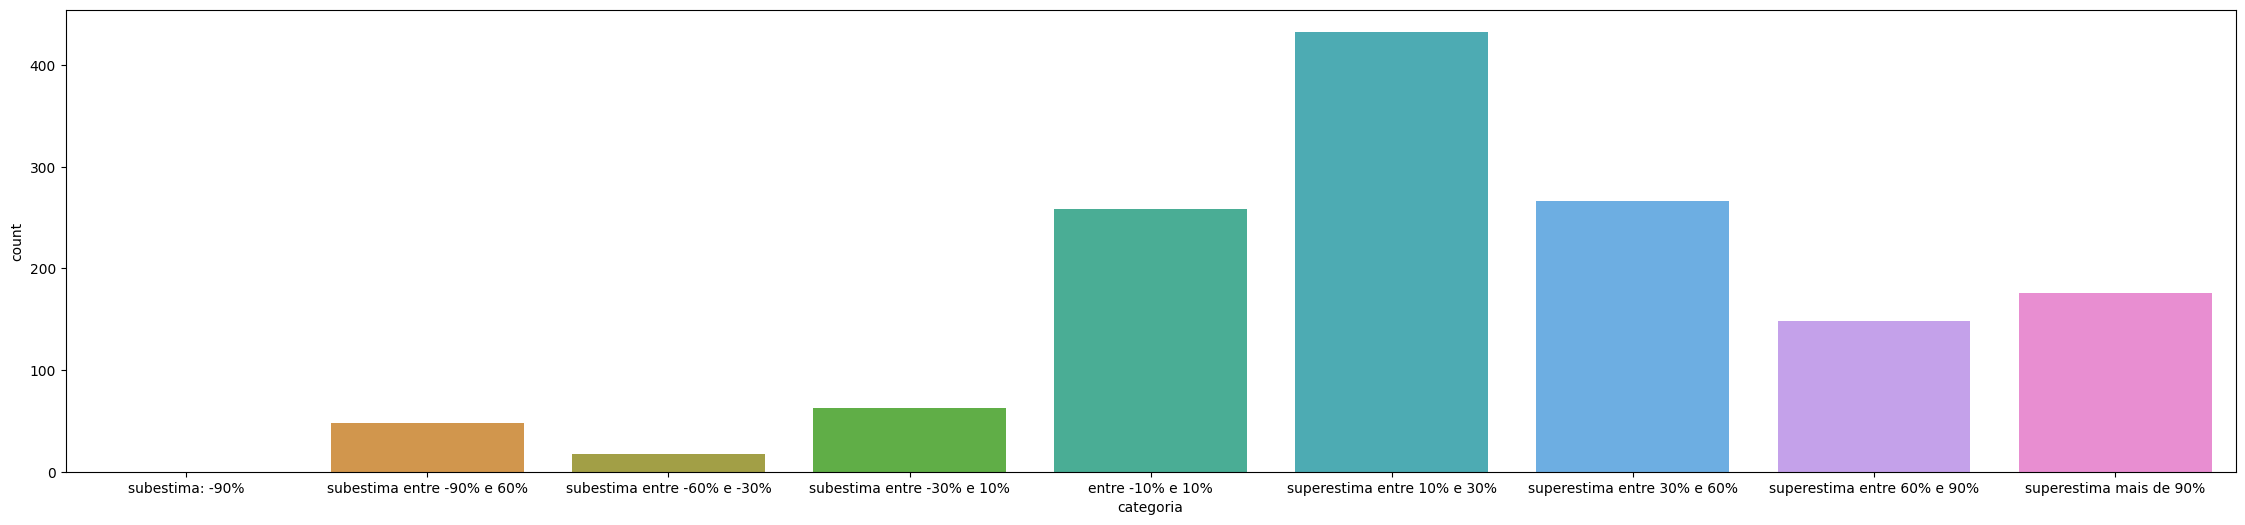

In [20]:
show_delta(np.array(y_test), y_pred.flatten())

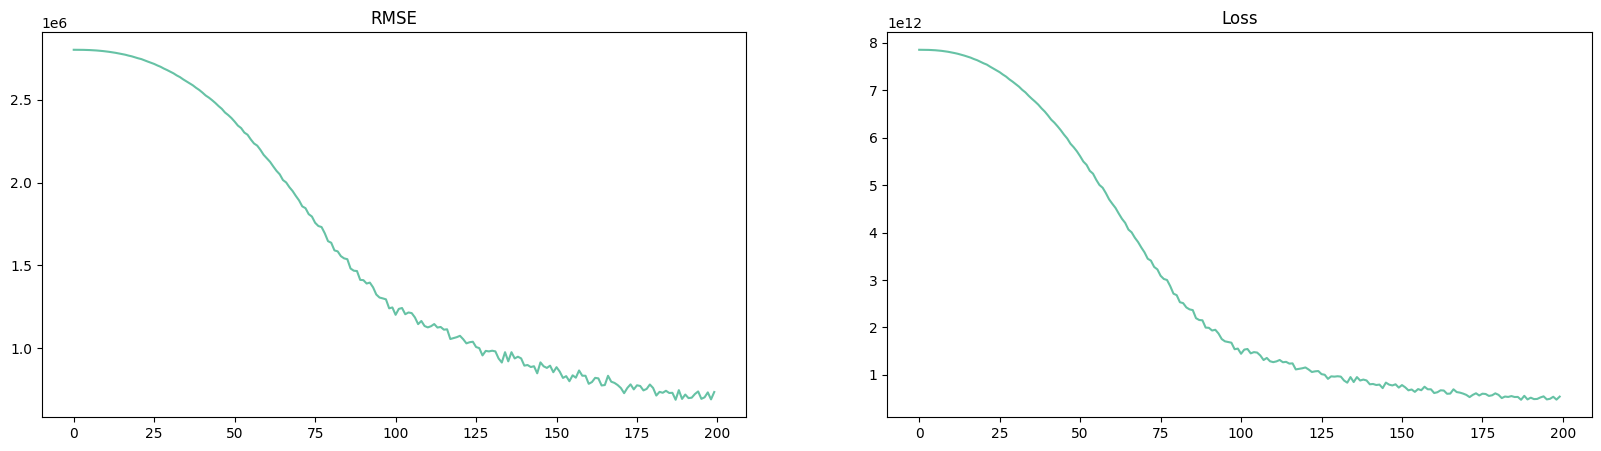

In [21]:
y = pd.read_csv(PATH + "target_ac.csv")
y = y["consumo"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

#model.add(BatchNormalization())
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),

model.add(BatchNormalization())

model.add(Dense(units=8, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [22]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

45/45 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 1136906.6507009747
MAE: 554594.1191960328
MAPE: 0.3556972107931319


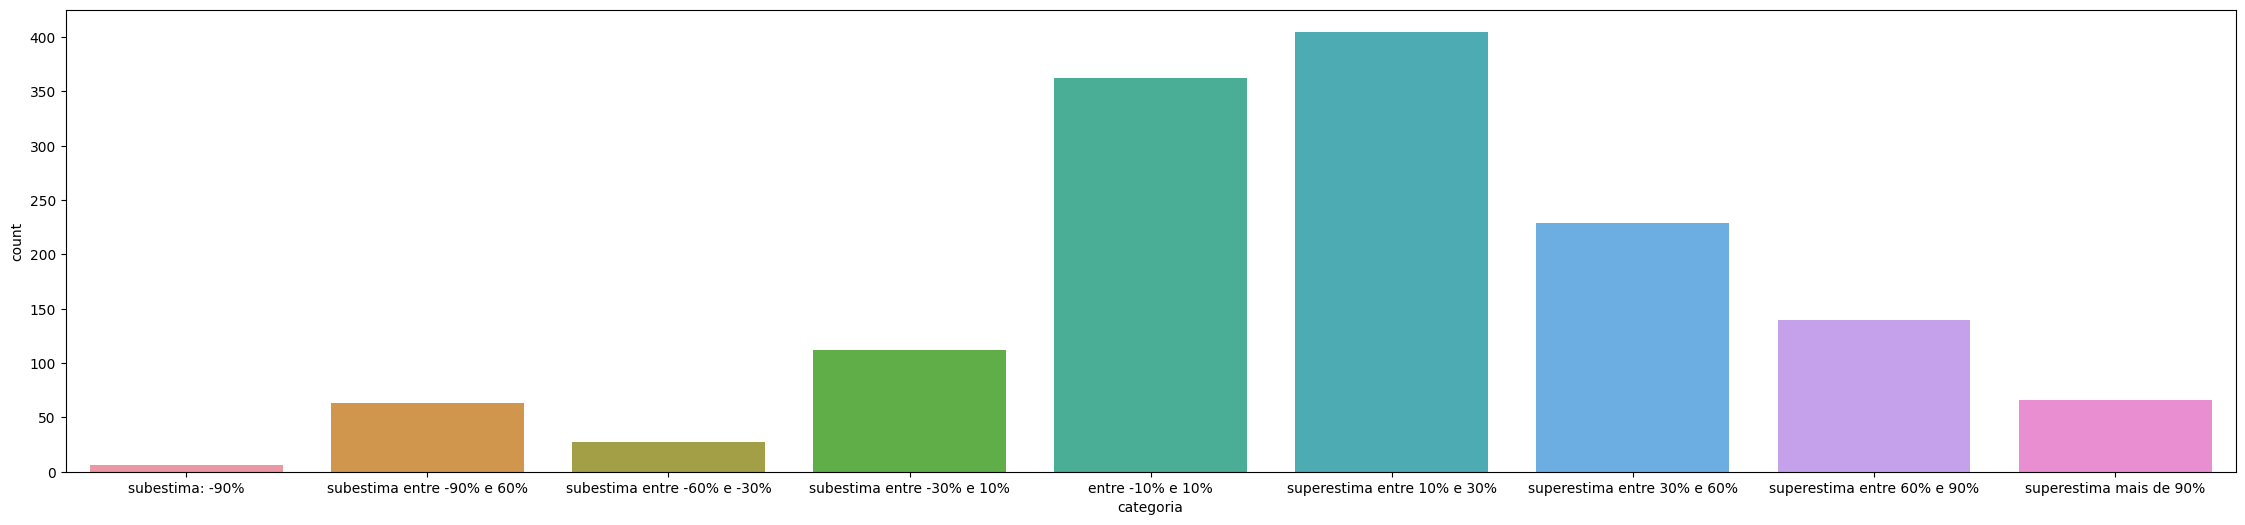

In [23]:
show_delta(np.array(y_test), y_pred.flatten())

In [24]:
df_geral["minmax scaler"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

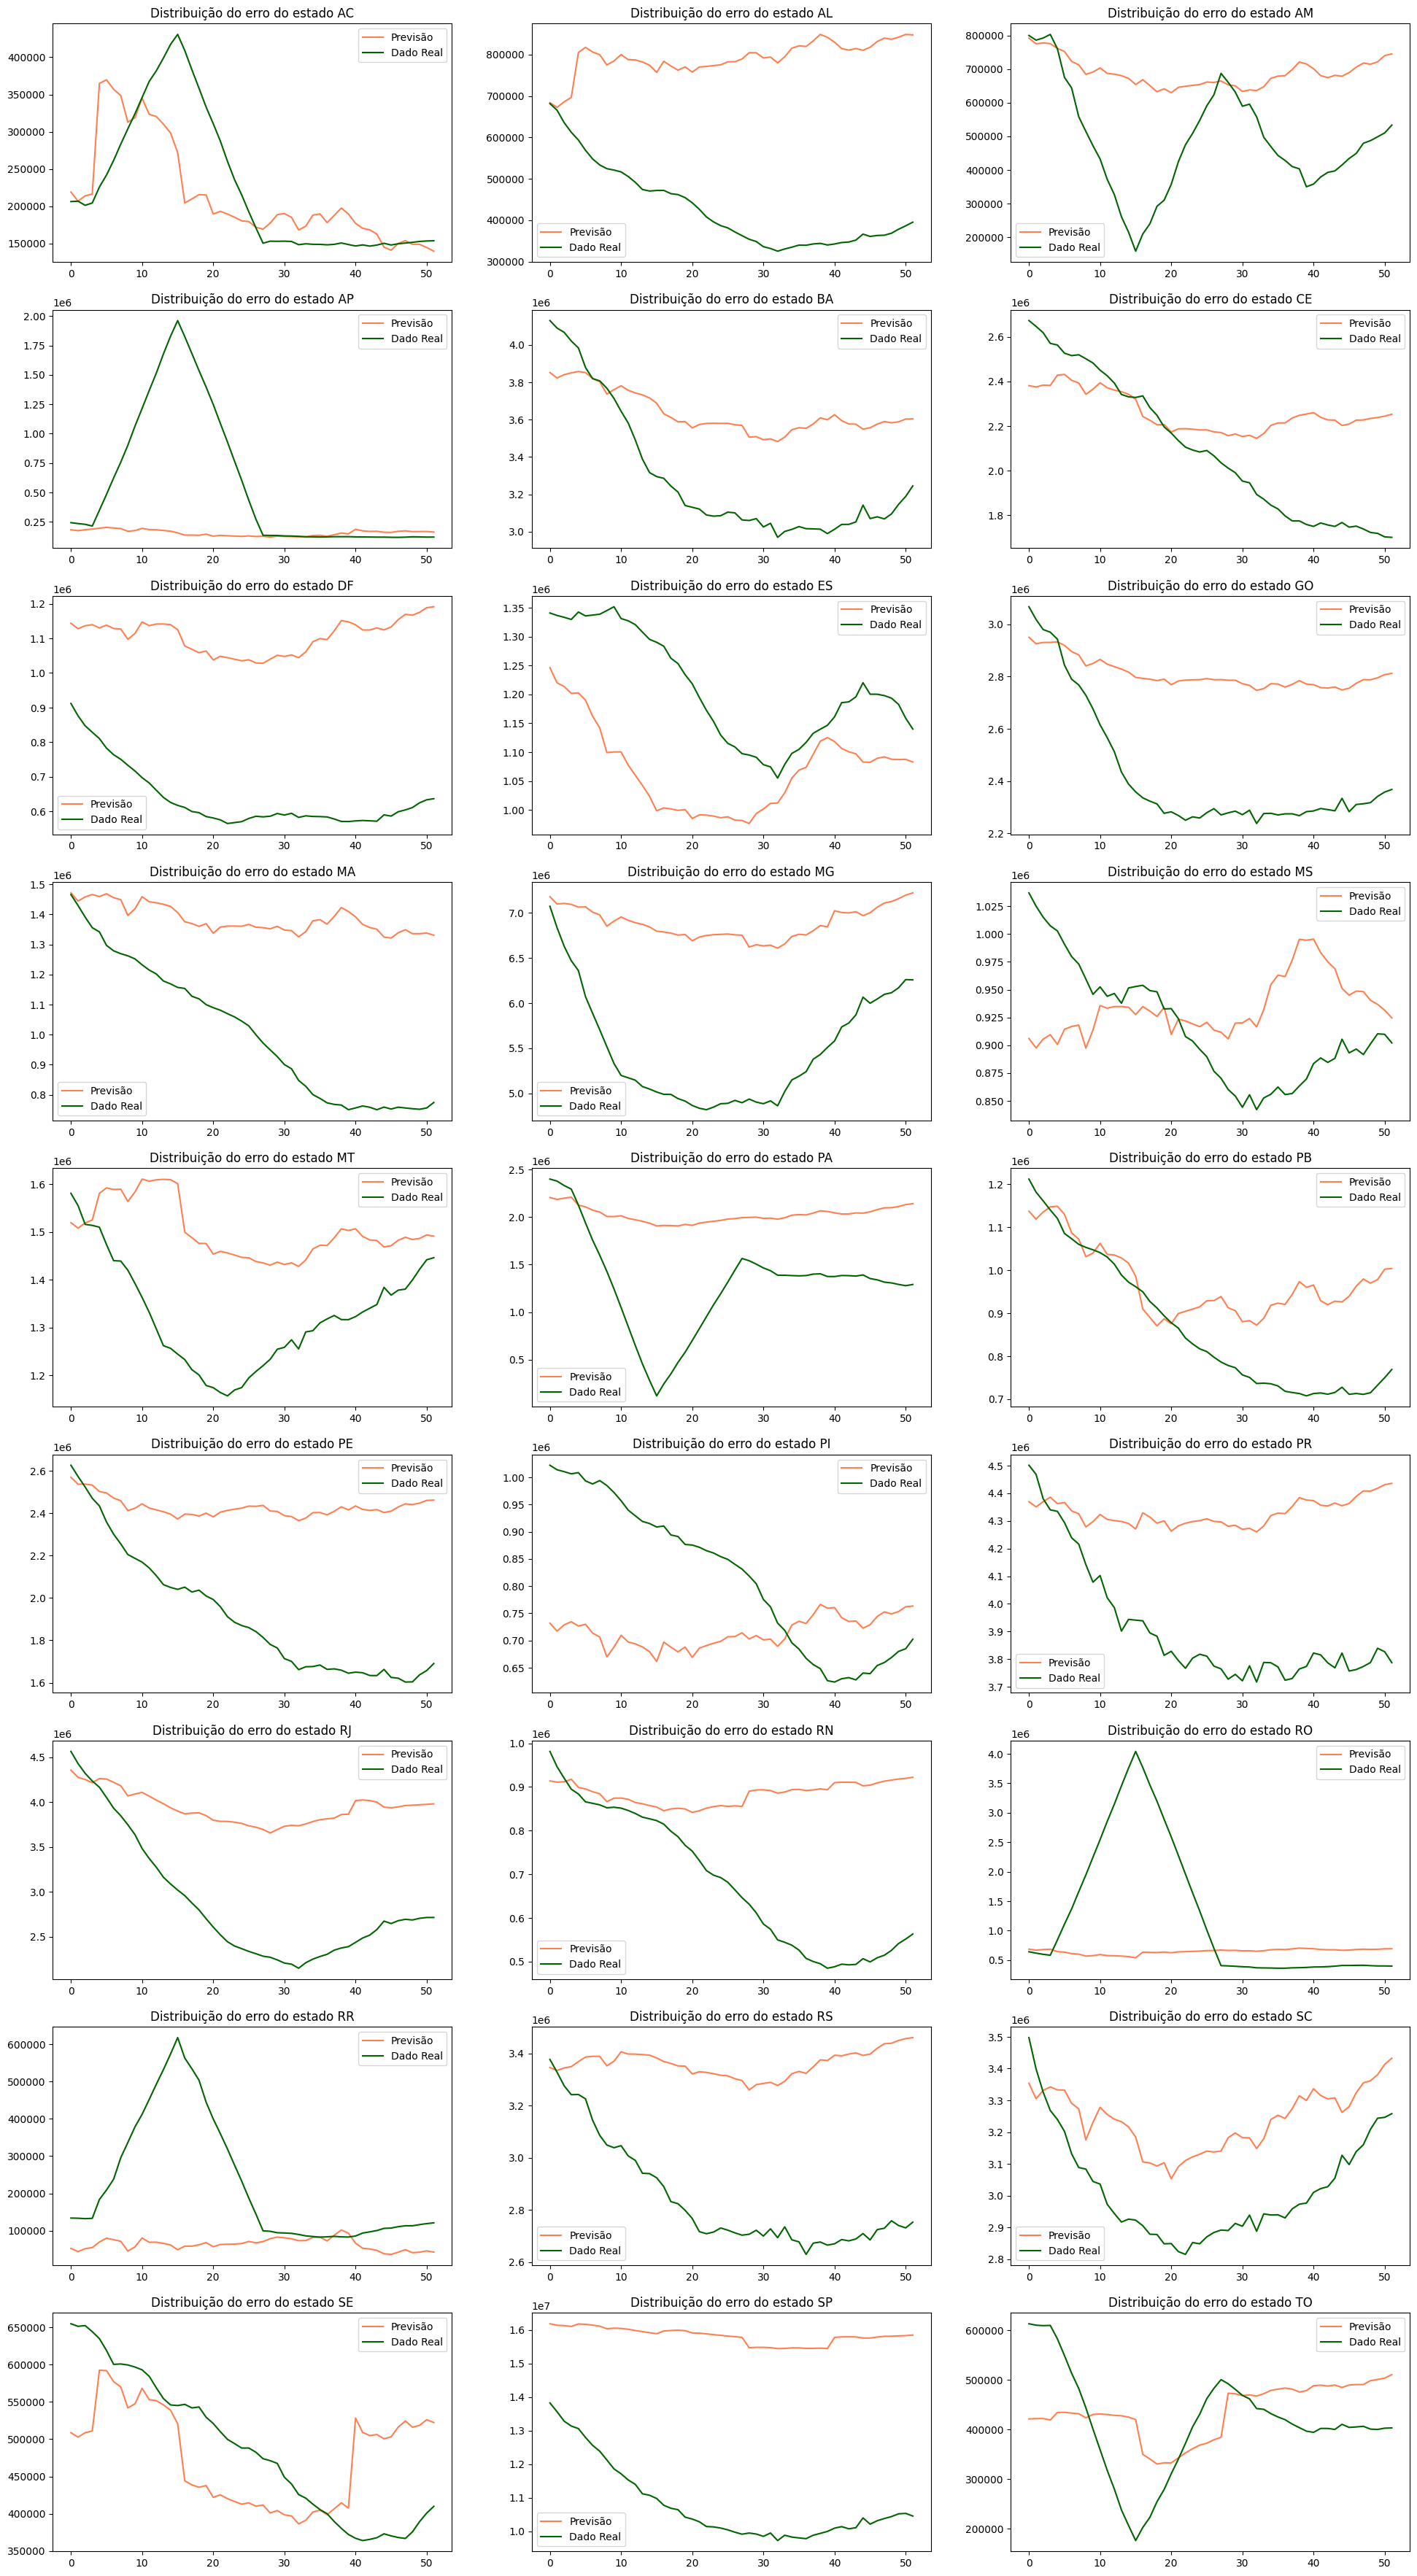

In [25]:
y_pred = y_pred[6:]
y_test = y_test[6:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)

## PowerTransform 

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = PowerTransformer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dense(units=16, activation="relu")),
model.add(Dense(units=8, activation="relu")),


model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

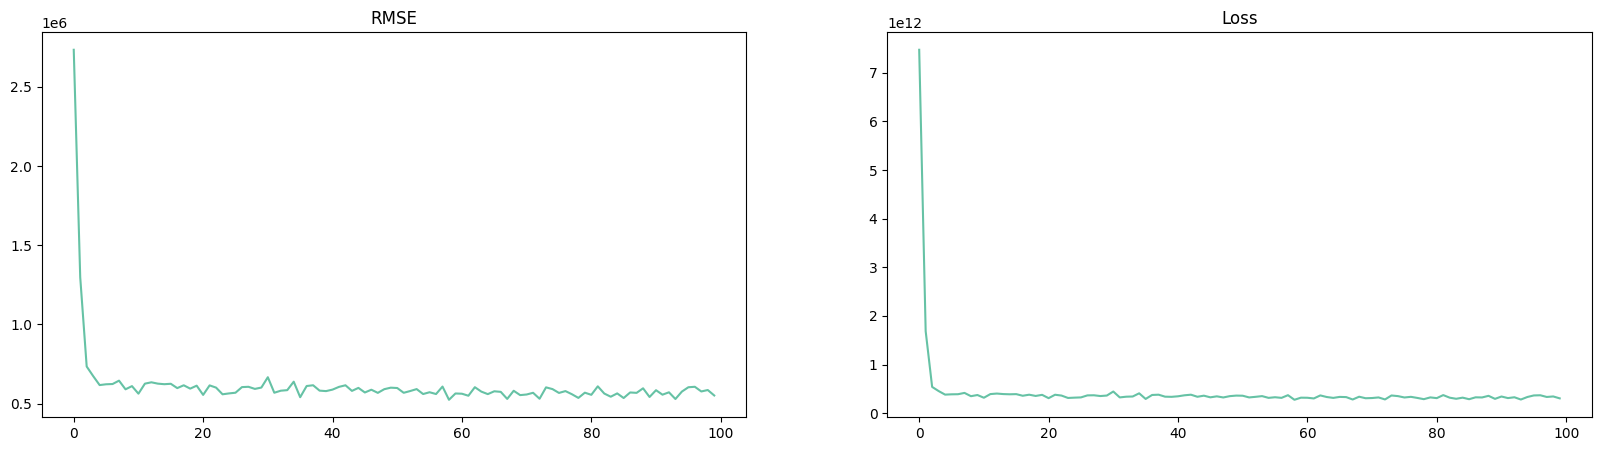

In [27]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [28]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

45/45 [==============================] - 0s 1ms/step
Scores obtidos:
RMSE: 761448.6950156328
MAE: 475656.3280972961
MAPE: 0.44941874965762646


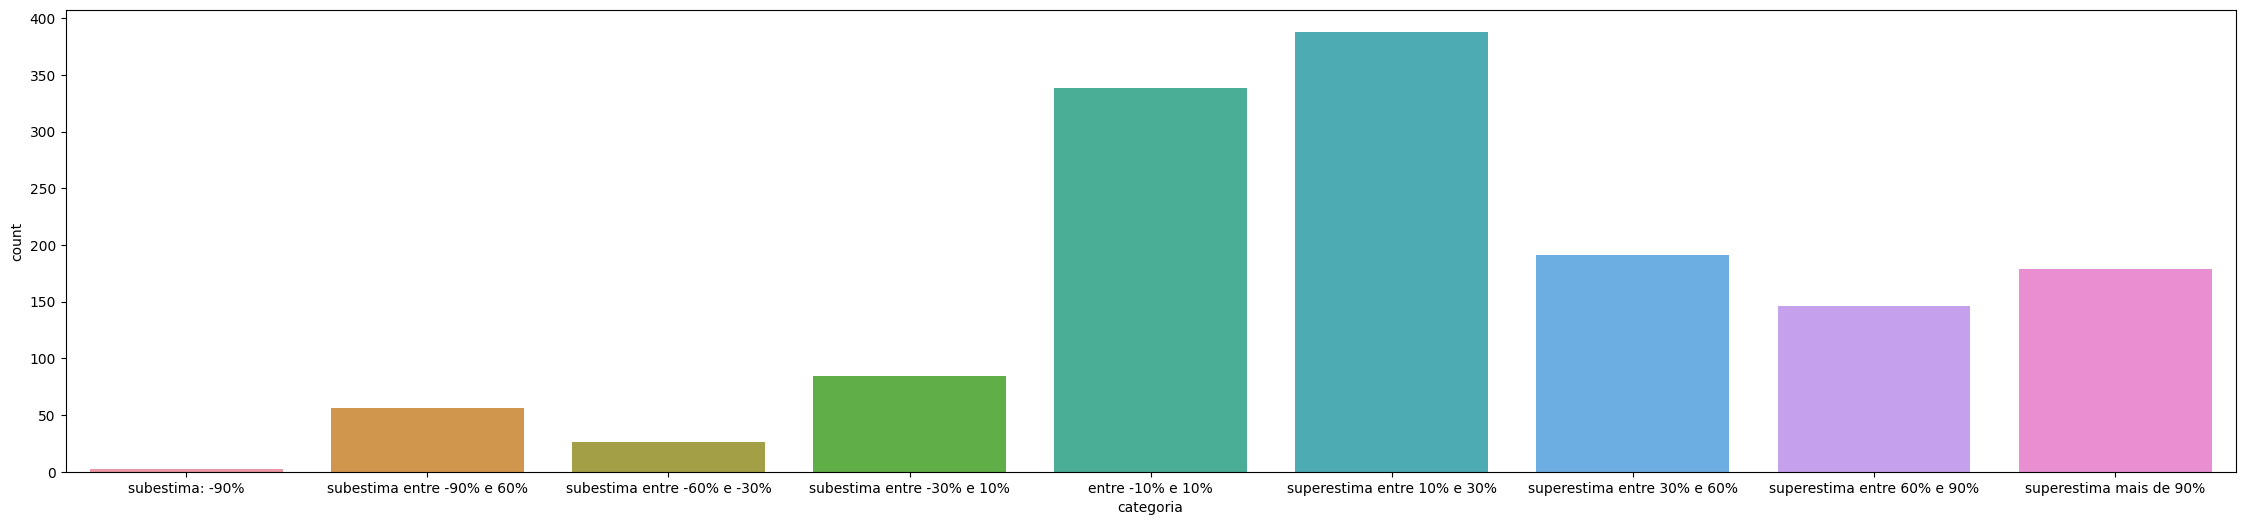

In [29]:
show_delta(np.array(y_test), y_pred.flatten())

In [30]:
df_geral["powertransform"] = [scores["neg_root_mean_squared_error"], scores["neg_mean_absolute_percentage_error"], scores["neg_mean_absolute_error"]]

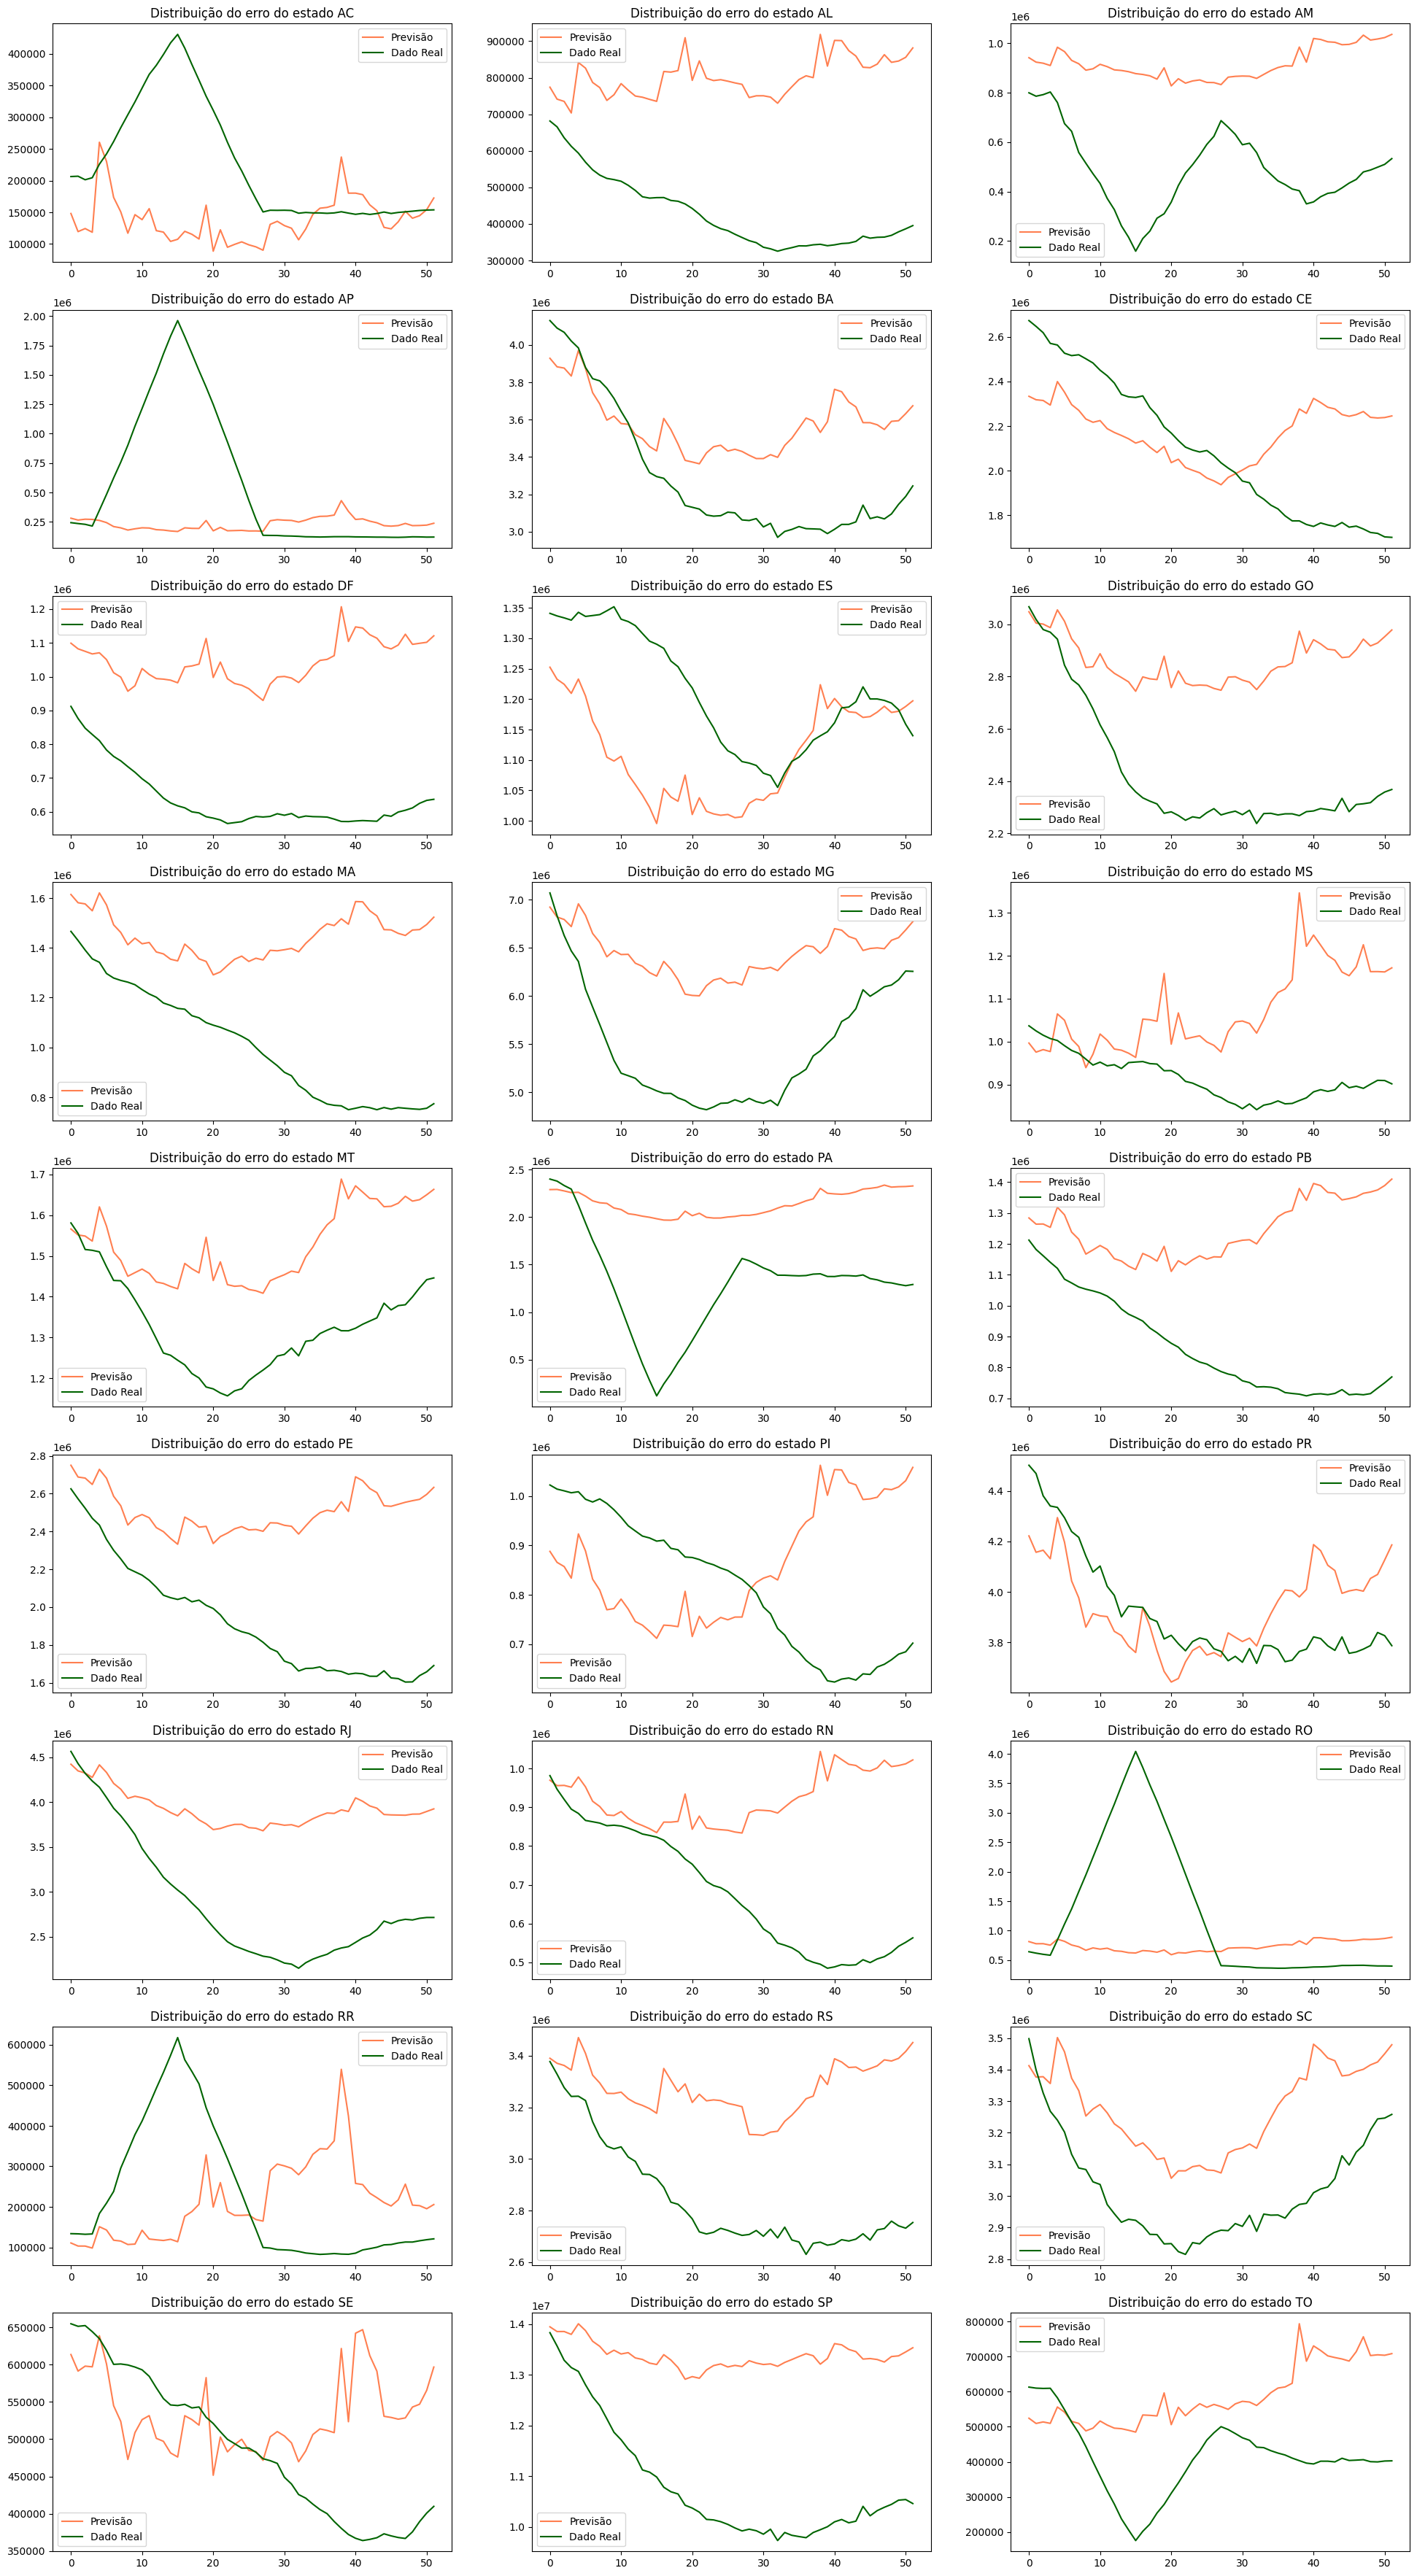

In [31]:
y_pred = y_pred[6:]
y_test = y_test[6:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)

In [33]:
df_geral

indicador  standard scaler  minmax scaler  powertransform
0      RMSE    832071.889954   1.136907e+06   761448.695016
1      MAPE         0.510515   3.556972e-01        0.449419
2       MAE    533653.124180   5.545941e+05   475656.328097

# Teste nos dados

In [41]:
from tensorflow.random import set_seed
SEED=47
os.environ['PYTHONHASHSEED'] = str(SEED)
set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [49]:
x = pd.read_csv(PATH+"input.csv")
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)
x.drop("data", axis=1, inplace=True)
#x = x[x["data"] != 201912]

In [54]:
y = pd.read_csv(PATH + "target_abs.csv")


In [55]:
y = pd.melt(y,id_vars=["data"], value_vars=SIGLAS, var_name="estados", value_name="consumo")

In [58]:
y = y[~y["data"].isin([199001, 199002, 199003, 199004, 199005, 199006, 199007, 199008, 199009, 199010, 199011, 201912])]["consumo"]

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200)

Epoch 1/200
250/250 [==============================] - 1s 2ms/step - loss: 23077076992.0000 - RMSE: 151911.4062
Epoch 2/200
250/250 [==============================] - 1s 2ms/step - loss: 13695509504.0000 - RMSE: 117027.8125
Epoch 3/200
250/250 [==============================] - 1s 2ms/step - loss: 11717091328.0000 - RMSE: 108245.5156
Epoch 4/200
250/250 [==============================] - 1s 2ms/step - loss: 11536887808.0000 - RMSE: 107409.9062
Epoch 5/200
250/250 [==============================] - 1s 2ms/step - loss: 11439057920.0000 - RMSE: 106953.5312
Epoch 6/200
250/250 [==============================] - 1s 2ms/step - loss: 11393477632.0000 - RMSE: 106740.2344
Epoch 7/200
250/250 [==============================] - 1s 2ms/step - loss: 11371660288.0000 - RMSE: 106637.9844
Epoch 8/200
250/250 [==============================] - 1s 4ms/step - loss: 11315991552.0000 - RMSE: 106376.6484
Epoch 9/200
250/250 [==============================] - 1s 5ms/step - loss: 11282518016.0000 - RMSE: 1062

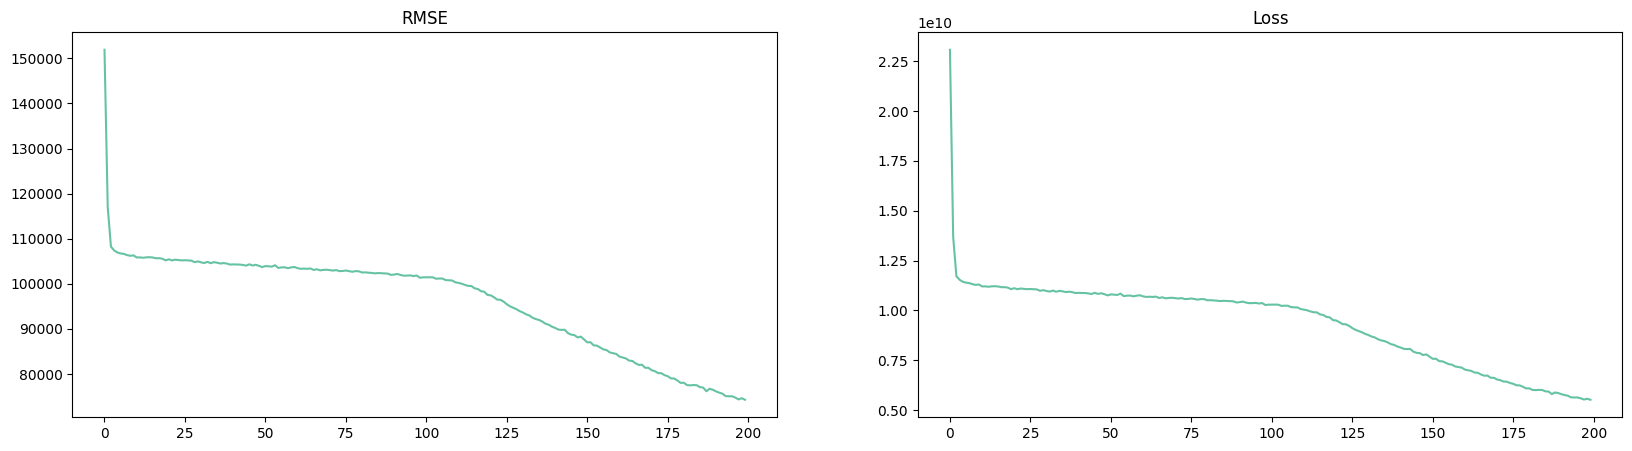

In [60]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [49]:
x = pd.read_csv(PATH+"input.csv")
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)
x.drop("data", axis=1, inplace=True)
y = pd.read_csv(PATH + "target_abs.csv")
y = pd.melt(y,id_vars=["data"], value_vars=SIGLAS, var_name="estados", value_name="consumo")
y = y[~y["data"].isin([199001, 199002, 199003, 199004, 199005, 199006, 199007, 199008, 199009, 199010, 199011, 201912])]["consumo"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200)

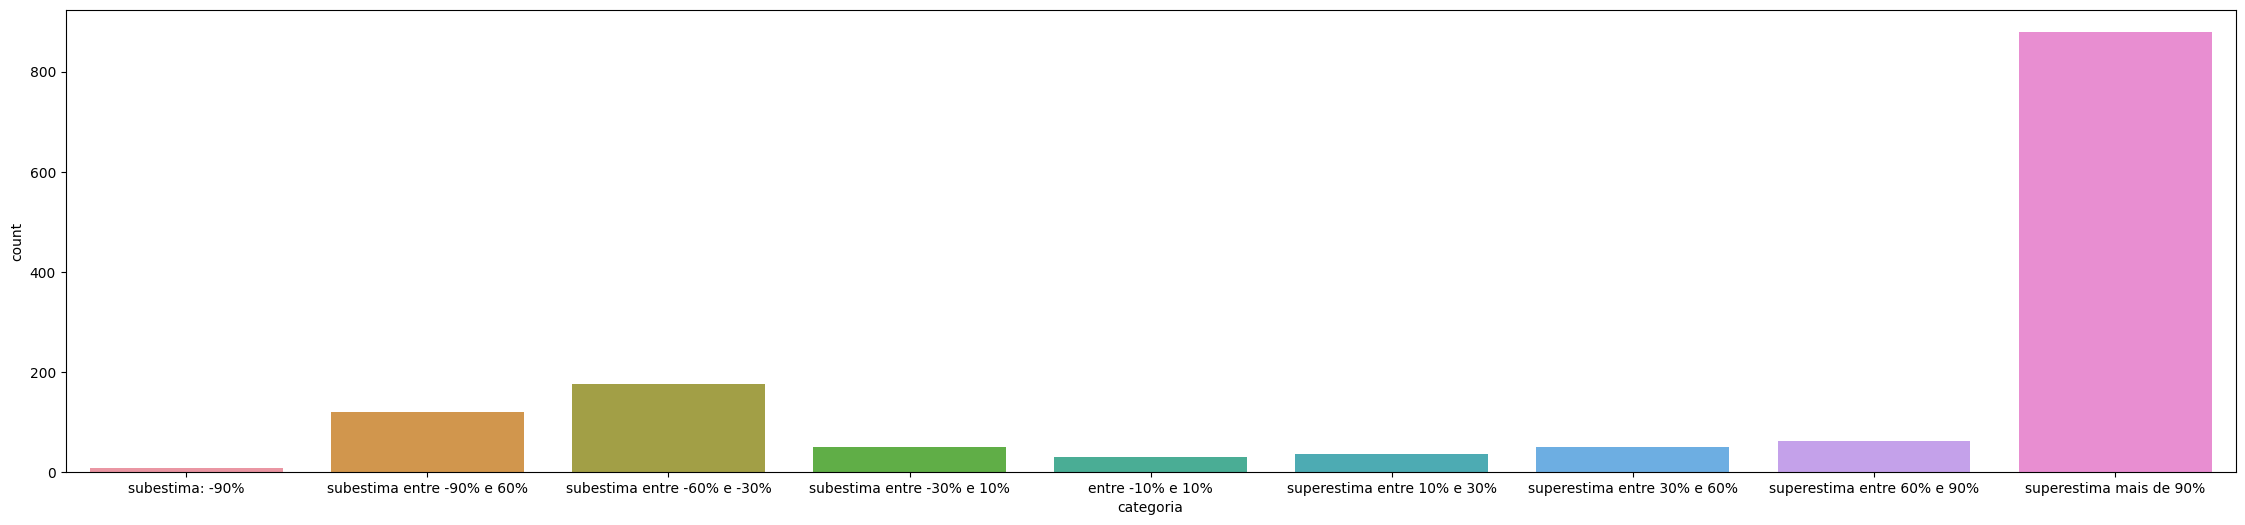

In [62]:
show_delta(np.array(y_test), y_pred.flatten())

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
scores = score_regression_metrics(y_train,model.predict(x_train))
show_scores(scores)
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

250/250 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 72702.35056648513
MAE: 51634.11114318043
MAPE: 2.1718416318970922e+17
45/45 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 417335.07373696385
MAE: 360064.55986464245
MAPE: 9.478732066865323


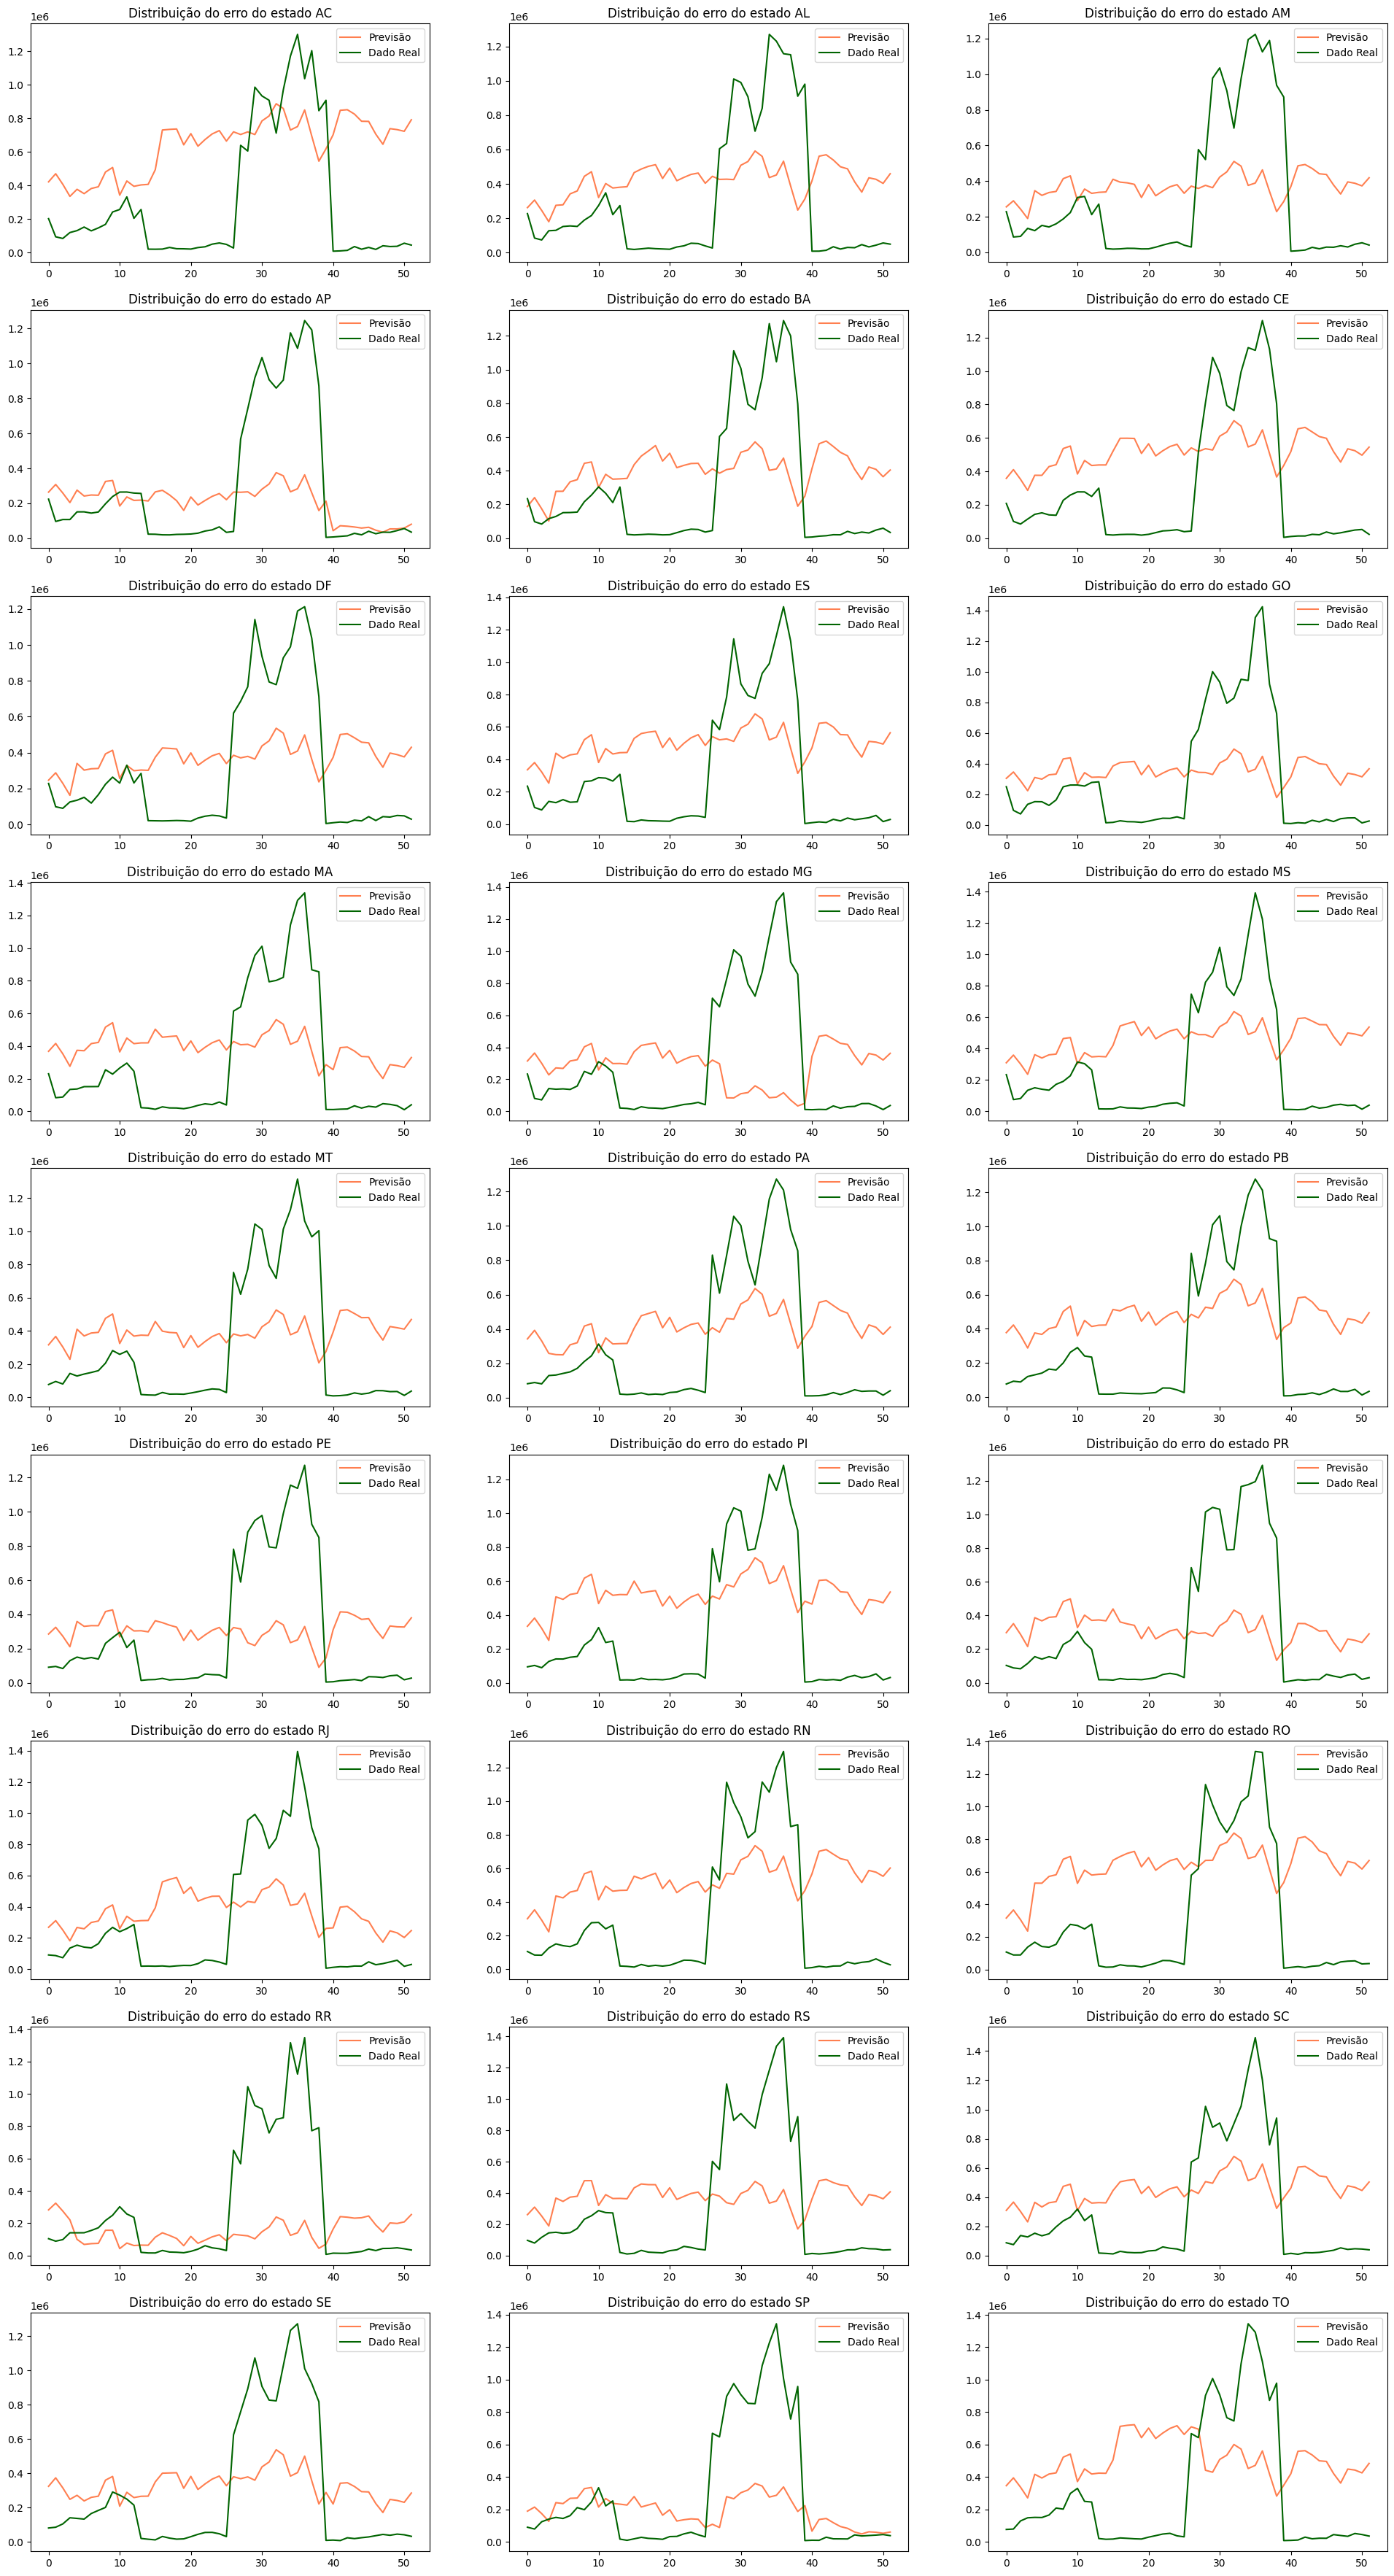

In [63]:
y_pred = y_pred[6:]
y_test = y_test[6:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)

In [53]:
y.shape

(9720,)

In [67]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200)

Epoch 1/200
250/250 [==============================] - 1s 3ms/step - loss: 23178889216.0000 - RMSE: 152246.1406
Epoch 2/200
250/250 [==============================] - 1s 3ms/step - loss: 14046408704.0000 - RMSE: 118517.5469
Epoch 3/200
250/250 [==============================] - 1s 3ms/step - loss: 12558244864.0000 - RMSE: 112063.5781
Epoch 4/200
250/250 [==============================] - 1s 3ms/step - loss: 12314979328.0000 - RMSE: 110972.8750
Epoch 5/200
250/250 [==============================] - 1s 3ms/step - loss: 12215528448.0000 - RMSE: 110523.8828
Epoch 6/200
250/250 [==============================] - 1s 3ms/step - loss: 12139016192.0000 - RMSE: 110177.2031
Epoch 7/200
250/250 [==============================] - 1s 3ms/step - loss: 12089159680.0000 - RMSE: 109950.7109
Epoch 8/200
250/250 [==============================] - 1s 3ms/step - loss: 12056487936.0000 - RMSE: 109802.0391
Epoch 9/200
250/250 [==============================] - 1s 4ms/step - loss: 11998355456.0000 - RMSE: 1095

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
scores = score_regression_metrics(y_train,model.predict(x_train))
show_scores(scores)
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)


250/250 [==============================] - 1s 2ms/step
Scores obtidos:
RMSE: 136265.88825950478
MAE: 90568.47577816238
MAPE: 1.026291665181096e+17
45/45 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 463995.8459620127
MAE: 267778.87654058065
MAPE: 0.9526077093183903


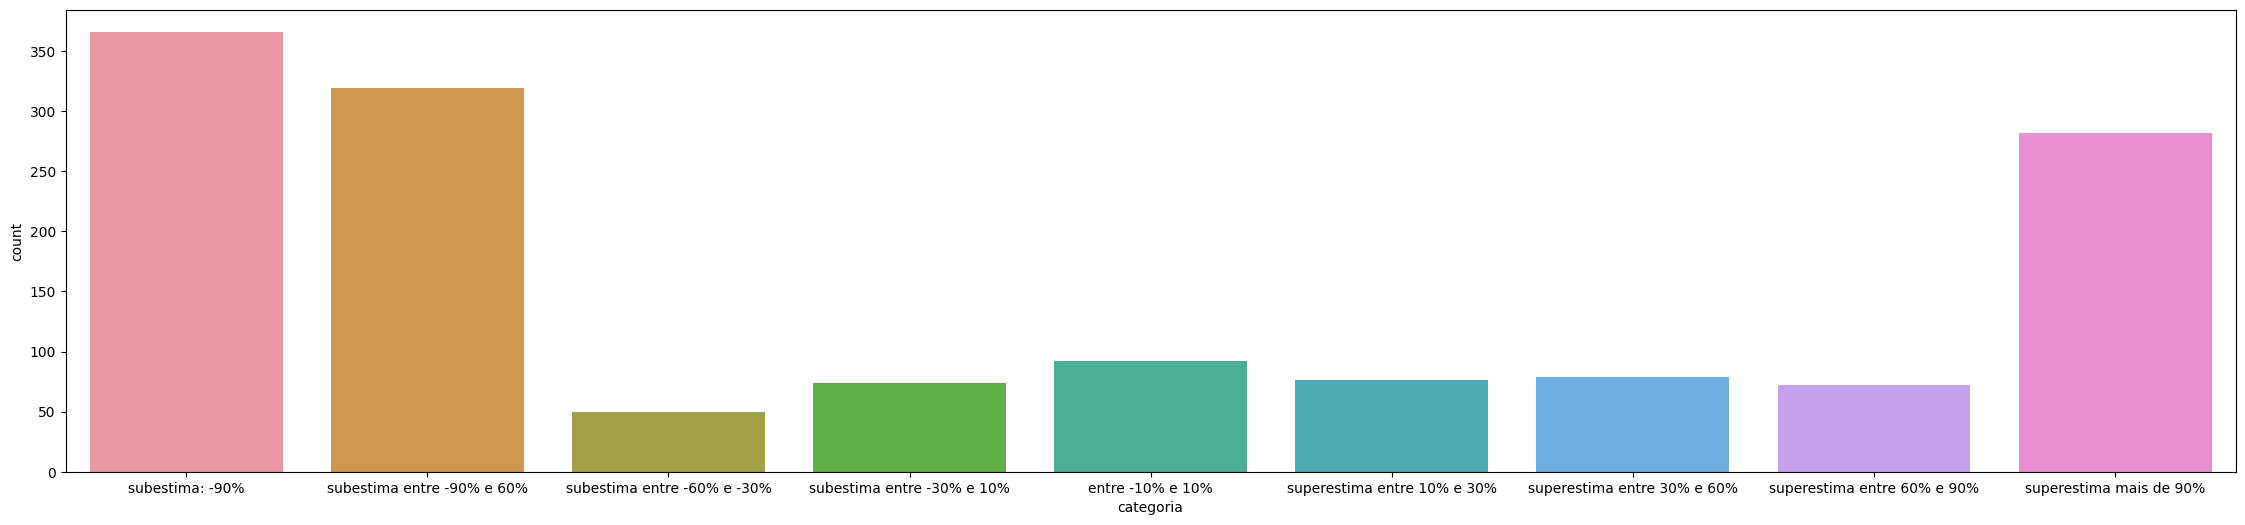

In [69]:
show_delta(np.array(y_test), y_pred.flatten())

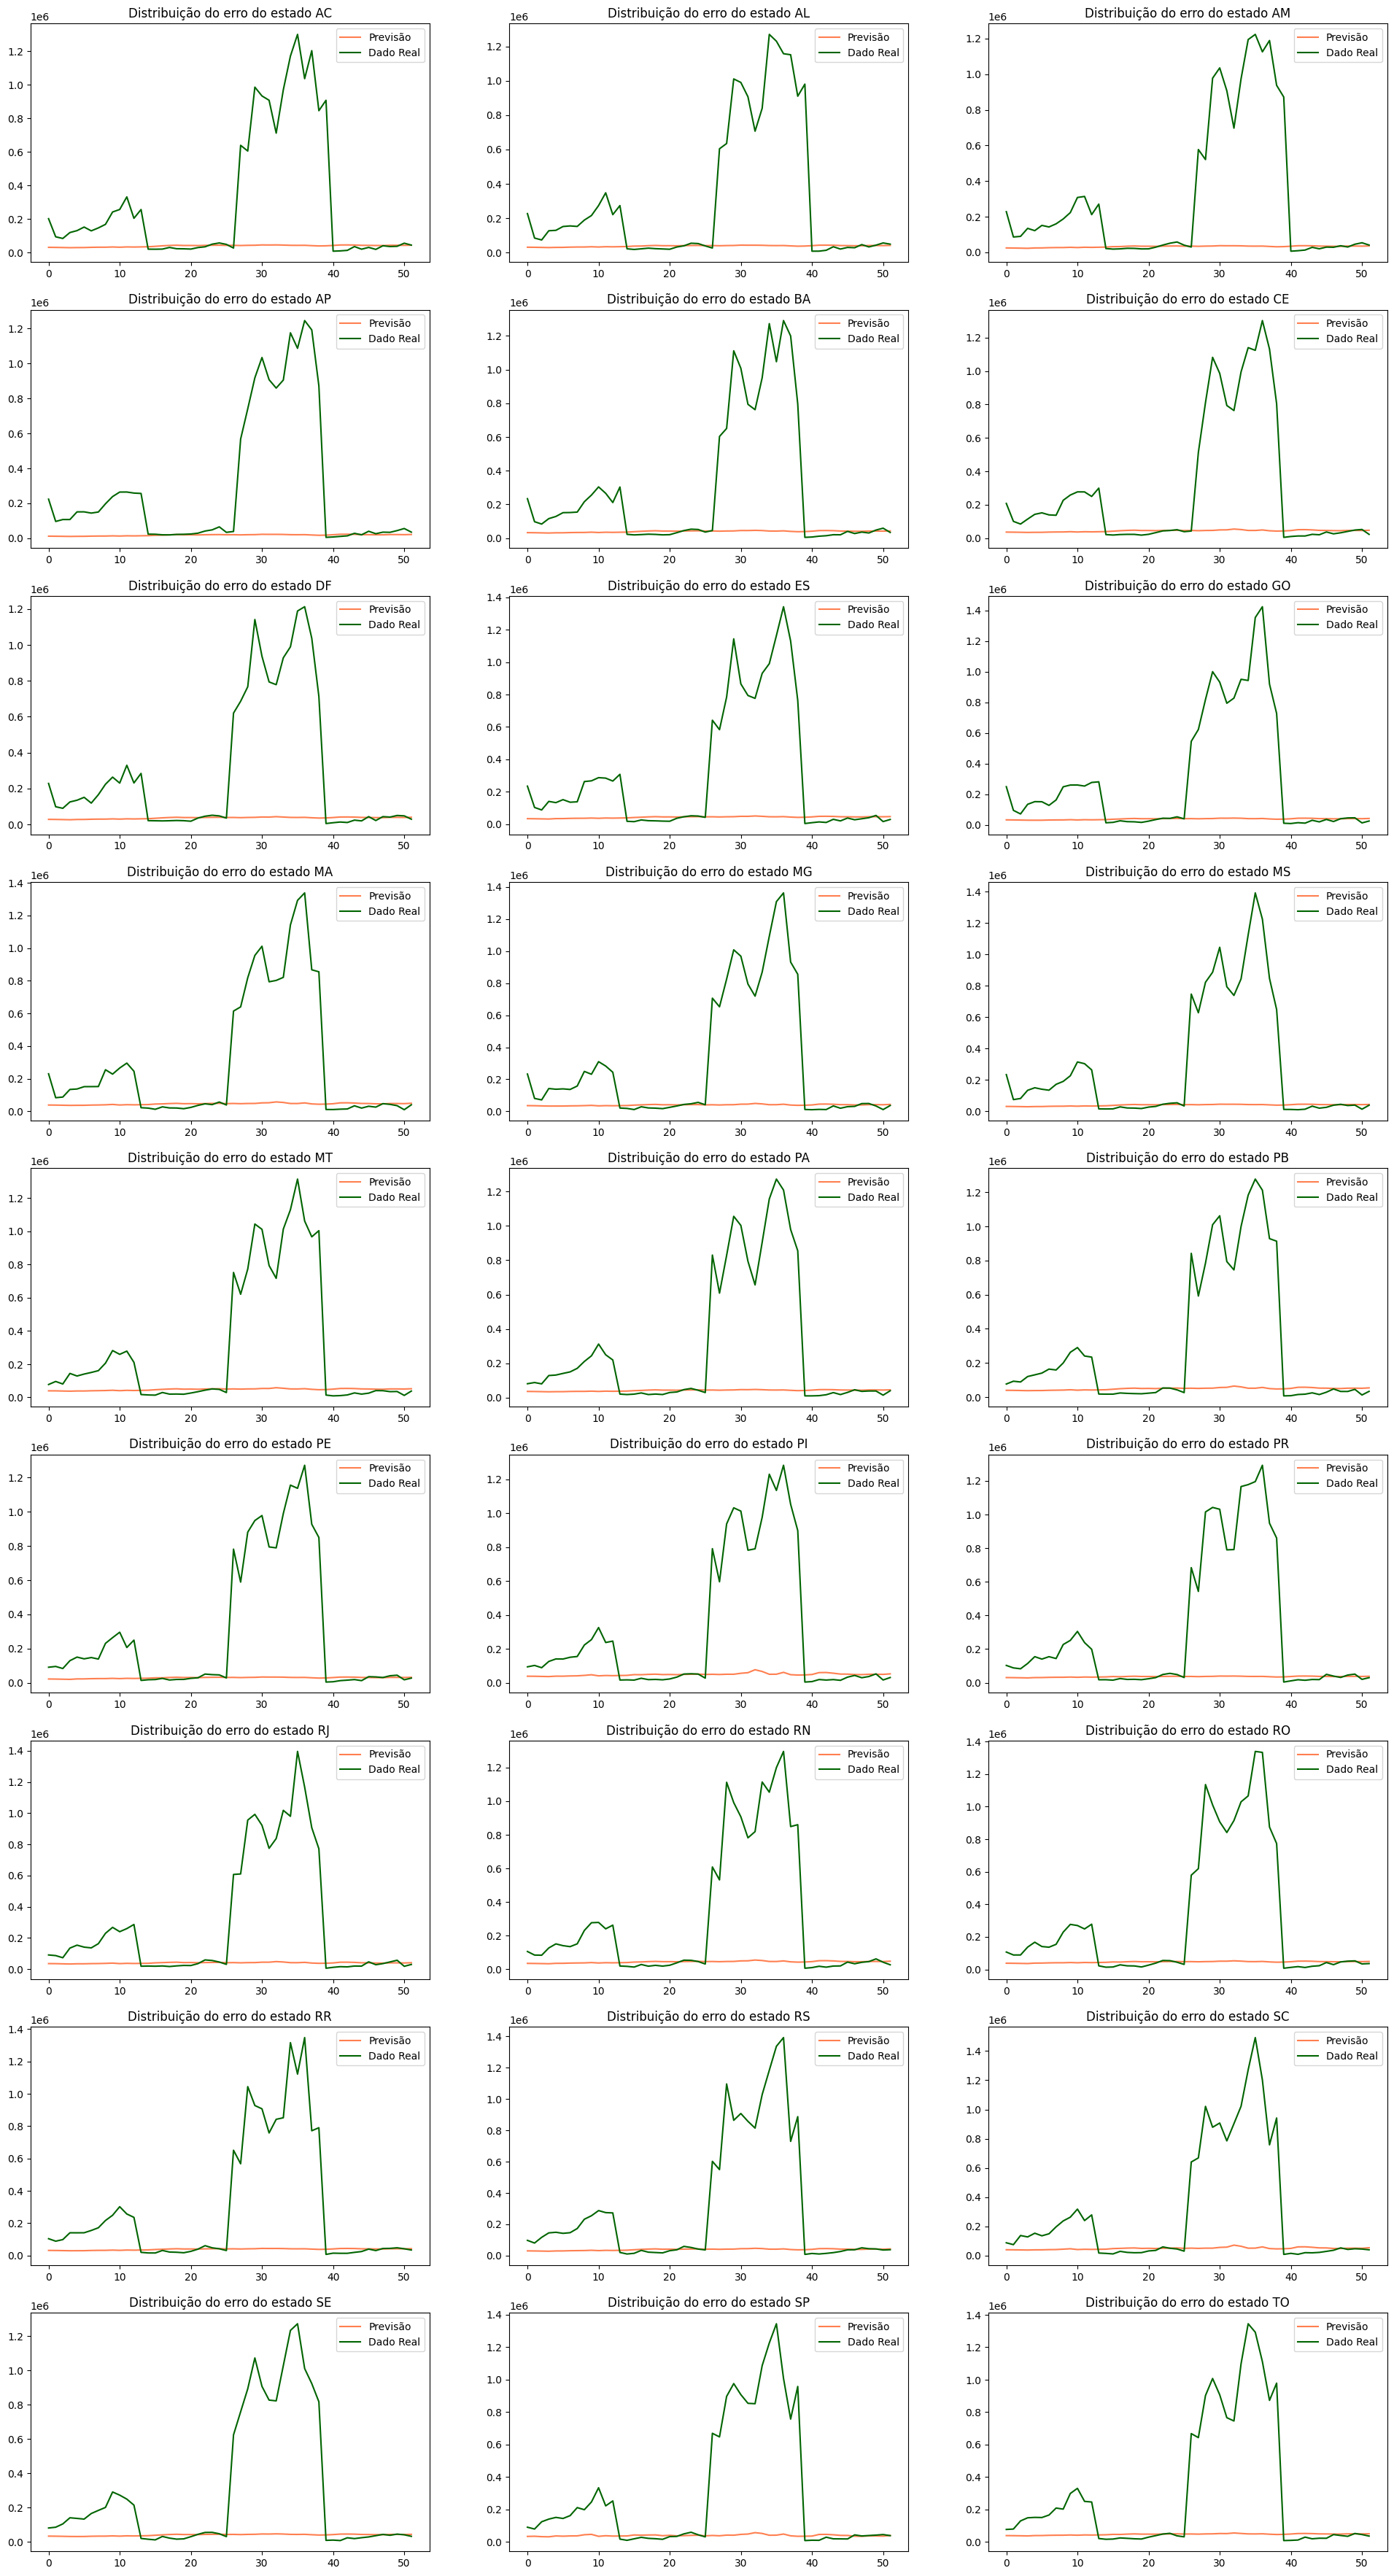

In [70]:
y_pred = y_pred[6:]
y_test = y_test[6:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)

In [ ]:
x = pd.read_csv(PATH+"input.csv")
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)
x.drop("data", axis=1, inplace=True)
y = pd.read_csv(PATH + "target_abs.csv")
y = pd.melt(y,id_vars=["data"], value_vars=SIGLAS, var_name="estados", value_name="consumo")
y = y[~y["data"].isin([199001, 199002, 199003, 199004, 199005, 199006, 199007, 199008, 199009, 199010, 199011, 201912])]["consumo"]

In [91]:
y = pd.read_csv(PATH + "target_abs.csv")
y = pd.melt(y,id_vars=["data"], value_vars=SIGLAS, var_name="estados", value_name="consumo")
y_ac = pd.DataFrame(SIGLAS, columns=["estados"])
y_ac

estados
0       AC
1       AL
2       AM
3       AP
4       BA
5       CE
6       DF
7       ES
8       GO
9       MA
10      MG
11      MS
12      MT
13      PA
14      PB
15      PE
16      PI
17      PR
18      RJ
19      RN
20      RO
21      RR
22      RS
23      SC
24      SE
25      SP
26      TO

In [94]:
ANO_INICIAL = 1991
ANO_FINAL = 2019

MESES = [f"{i:02d}" for i in range(1, 13)]

# datas usadas (de janeiro de 1991 ate dezembro de 2019)
# formato: yyyymmm => 199101 -> jan/1991
ANO_MES = [a+m for a in [f"{i}" for i in range(ANO_INICIAL, ANO_FINAL+1)] for m in MESES]
ANO_MES = ["199012"] + ANO_MES

In [104]:
y_ac = pd.read_csv(PATH + "target_ac.csv")


In [106]:
y_ac = y_ac[y_ac["data"] >= 199201]

In [108]:
x = pd.read_csv(PATH+"input.csv")
x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)
x = x[x['data'] < 201900]
x.drop("data", axis=1, inplace=True)

In [113]:
y_ac.shape

(9072, 3)

In [114]:
x.shape

(9072, 41)

In [118]:
y = y_ac["consumo"]

In [119]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),
model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200)

Epoch 1/200
241/241 [==============================] - 2s 5ms/step - loss: 7826241486848.0000 - RMSE: 2797542.0000
Epoch 2/200
241/241 [==============================] - 1s 6ms/step - loss: 7327233605632.0000 - RMSE: 2706886.2500
Epoch 3/200
241/241 [==============================] - 1s 5ms/step - loss: 5849743360000.0000 - RMSE: 2418624.2500
Epoch 4/200
241/241 [==============================] - 1s 4ms/step - loss: 5319250935808.0000 - RMSE: 2306350.2500
Epoch 5/200
241/241 [==============================] - 1s 5ms/step - loss: 5223451459584.0000 - RMSE: 2285487.2500
Epoch 6/200
241/241 [==============================] - 1s 5ms/step - loss: 5183612911616.0000 - RMSE: 2276755.0000
Epoch 7/200
241/241 [==============================] - 1s 5ms/step - loss: 5125746720768.0000 - RMSE: 2264011.2500
Epoch 8/200
241/241 [==============================] - 1s 5ms/step - loss: 5090635677696.0000 - RMSE: 2256243.7500
Epoch 9/200
241/241 [==============================] - 1s 6ms/step - loss: 50222

In [120]:
y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

43/43 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 2248602.234556304
MAE: 1695462.3309147686
MAPE: 2.6973418198493238


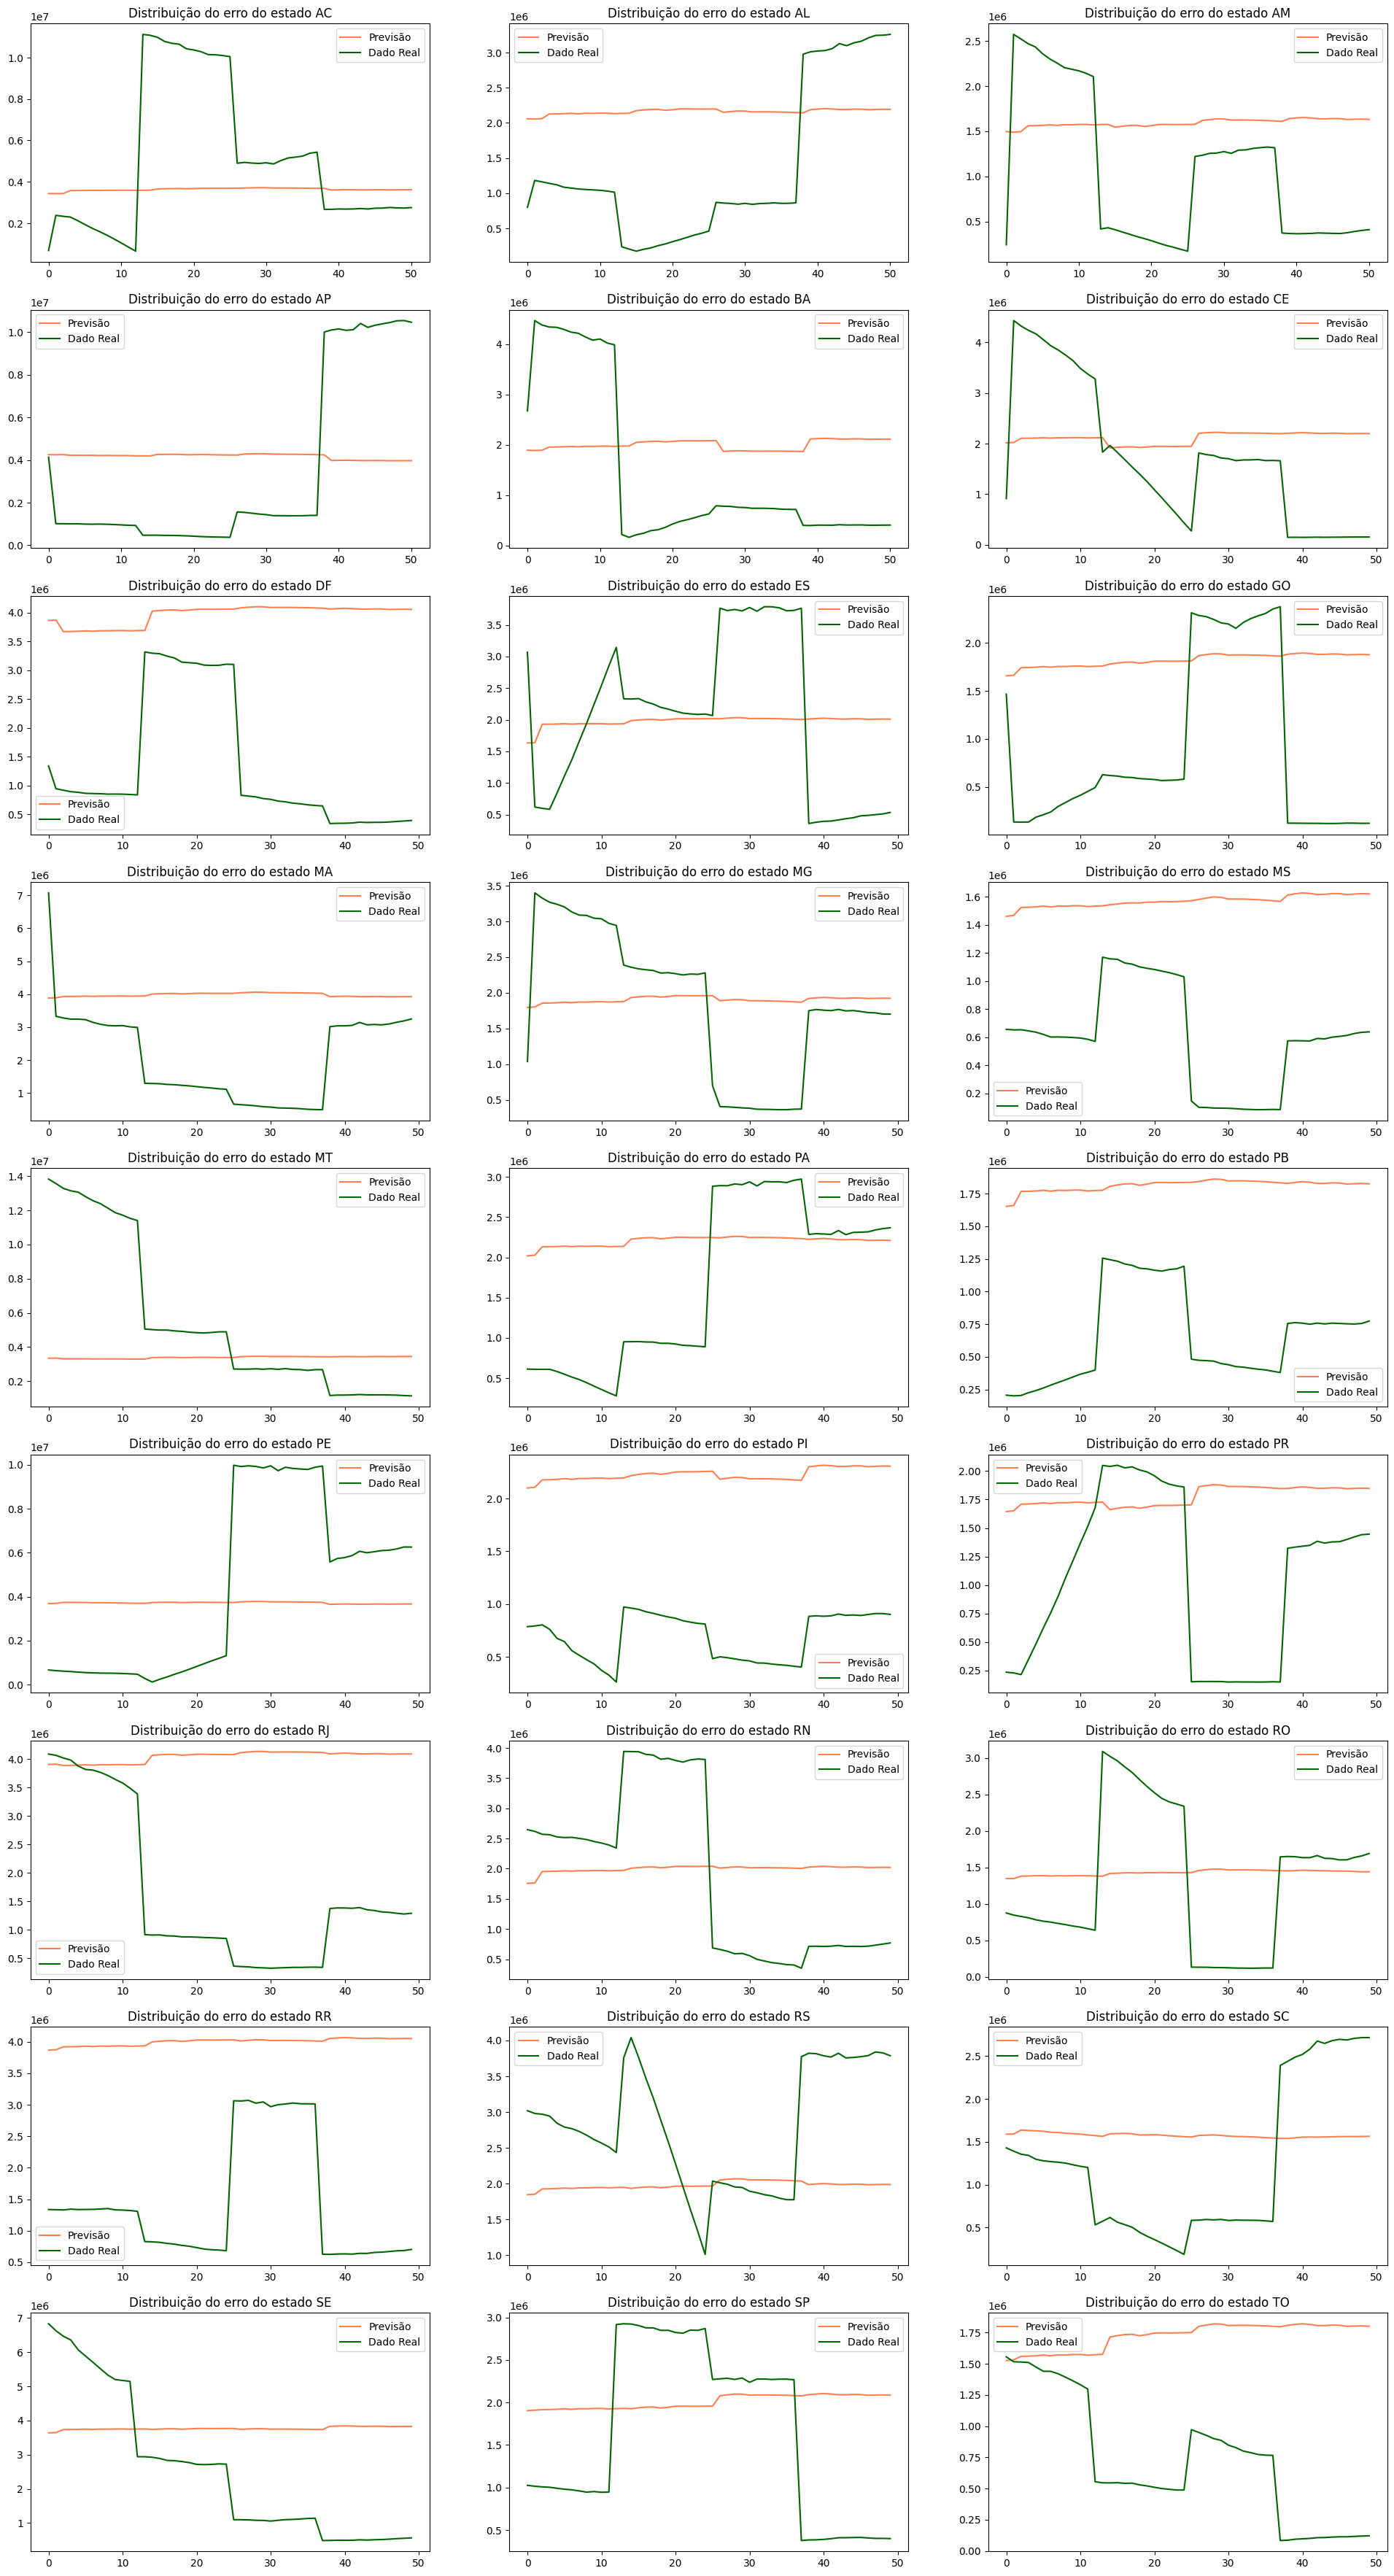

In [121]:
y_pred = y_pred[6:]
y_test = y_test[6:]

y_pred_state = split_y_state(y_pred)
y_test_state = split_y_state(y_test)

pred = {}

for i in range(27):
    pred[SIGLAS[i]] = {"y_test":y_test_state[i],
                       "y_pred":y_pred_state[i]}
show_predictions_graphs(pred)

In [127]:
y_ac

data estados     consumo
12    199201      MT    334596.0
13    199202      PA    436829.0
14    199203      PB    368891.0
15    199204      PE    923087.0
16    199205      PI    132886.0
...      ...     ...         ...
9391  201908      RS   2753564.0
9392  201909      SC   3258027.0
9393  201910      SE    409903.0
9394  201911      SP  10458276.0
9395  201912      TO    402932.0

[9072 rows x 3 columns]

In [128]:
y = pd.read_csv(PATH + "target_abs.csv")

In [129]:
y

data       AC       AL       AM       AP        BA        CE       DF  \
0    199001   1450.0  27421.0  21819.0    275.0   98829.0   47569.0  32020.0   
1    199002    938.0  20324.0  22683.0   1000.0   79133.0   42856.0  31612.0   
2    199003   1160.0  18584.0  13819.0   1100.0   72574.0   22004.0  37038.0   
3    199004      0.0  20972.0  16168.0   1000.0   77964.0   29635.0  32340.0   
4    199005   1643.0  30874.0  22104.0   2015.0  102595.0   45320.0  34414.0   
..      ...      ...      ...      ...      ...       ...       ...      ...   
355  201908  16723.0  32378.0  53567.0  11342.0  281466.0  164440.0  64127.0   
356  201909  15253.0  32582.0  46239.0  13110.0  285535.0  140298.0  60822.0   
357  201910  16531.0  42703.0  51066.0  13195.0  328259.0  168407.0  65182.0   
358  201911  15206.0  38584.0  51684.0  10053.0  298078.0  163615.0  51282.0   
359  201912  10160.0  36503.0  44907.0  12274.0  264838.0  155070.0  43554.0   

           ES        GO  ...        PR        RJ       RN       RO       RR  \
0     52437.0   57264.0  ...  142103.0  221533.0  19353.0   9903.0   2040.0   
1     36737.0   65472.0  ...  125305.0  183828.0  15043.0   8953.0   2029.0   
2     40234.0   58816.0  ...  112970.0  182124.0  10654.0   6200.0   2367.0   
3     40937.0   56475.0  ...  113938.0  172505.0  11015.0   3774.0    751.0   
4     53728.0   73296.0  ...  146154.0  241736.0  10916.0  11742.0   1774.0   
..        ...       ...  ...       ...       ...      ...      ...      ...   
355  104711.0  226996.0  ...  356169.0  244870.0  54306.0  40300.0   9654.0   
356   97530.0  218141.0  ...  316188.0  225410.0  52511.0  35493.0   9422.0   
357   99651.0  234939.0  ...  346214.0  252849.0  59472.0  38489.0  11160.0   
358   76710.0  199619.0  ...  323401.0  226618.0  54022.0  35591.0  10491.0   
359   75456.0  168797.0  ...  238466.0  190993.0  49791.0  27530.0  10225.0   

           RS        SC       SE        SP       TO  
0    138590.0   91667.0  23721.0  639210.0   3258.0  
1     89165.0   65132.0  14096.0  593101.0   2958.0  
2    109681.0   75893.0  14728.0  573829.0   3735.0  
3    108513.0   78178.0  15560.0  549760.0   2866.0  
4    138613.0   95485.0  19020.0  676138.0   7227.0  
..        ...       ...      ...       ...      ...  
355  249519.0  299284.0  29860.0  978990.0  40046.0  
356  230086.0  284550.0  39045.0  906956.0  32647.0  
357  233136.0  307576.0  45213.0  980948.0  39065.0  
358  233800.0  281317.0  42237.0  872046.0  36180.0  
359  223214.0  226233.0  39732.0  692232.0  28749.0  

[360 rows x 28 columns]